In [2]:
!pip install --upgrade pip

In [5]:
!pip install -r requirements.txt

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

# ── Data ──────────────────────────────────────────────────
import pandas as pd
import numpy as np
from scipy import stats

# ── Visualisation ─────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ── Classical ML (used later, imported here to catch errors early) ─────────────
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# ── Quantum ────────────────────────────────────────────────
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Optimizers — use scipy directly (avoids BaseSampler conflict)
from scipy.optimize import minimize
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals

# ── Reproducibility ────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
algorithm_globals.random_seed = SEED

# ── Plot style ─────────────────────────────────────────────
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)

print("✅  All imports successful")

✅  All imports successful


In [7]:
import sys
print(sys.executable)  # This shows which Python the kernel is actually using

/opt/homebrew/Caskroom/miniforge/base/envs/quantum_env/bin/python3


In [8]:
import sys
!{sys.executable} -m pip install pandas numpy scipy scikit-learn matplotlib seaborn qiskit "qiskit-aer<0.16.0,>=0.14.0" "qiskit-machine-learning<0.8.0,>=0.7.2" "qiskit-algorithms<0.4.0,>=0.3.0" tqdm --quiet

In [2]:
import sys
!{sys.executable} -m pip install \
    "qiskit==1.2.4" \
    "qiskit-aer==0.15.1" \
    "qiskit-machine-learning==0.7.2" \
    "qiskit-algorithms==0.2.2" \
    --force-reinstall --quiet

In [4]:
df_raw = pd.read_csv("telco_churn_data.csv")

In [5]:
print("── First 5 rows ─────────────────────────────────────────────────────────────")
display(df_raw.head())

print("\n── Last 5 rows ──────────────────────────────────────────────────────────────")
display(df_raw.tail())

── First 5 rows ─────────────────────────────────────────────────────────────


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.8500,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.9500,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.8500,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3000,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7000,151.65,Yes



── Last 5 rows ──────────────────────────────────────────────────────────────


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.8000,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.2000,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.6000,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.4000,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.6500,6844.5,No


In [6]:
print("── DataFrame Info ───────────────────────────────────────────────────────────")
df_raw.info()

── DataFrame Info ───────────────────────────────────────────────────────────
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract   

In [7]:
numeric_cols      = df_raw.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols  = df_raw.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric columns   ({len(numeric_cols)})  : {numeric_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}):")
for col in categorical_cols:
    uniq = df_raw[col].nunique()
    print(f"  {col:<30} — {uniq} unique values  {df_raw[col].unique()[:6]}")

Numeric columns   (3)  : ['SeniorCitizen', 'tenure', 'MonthlyCharges']

Categorical columns (18):
  customerID                     — 7043 unique values  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU'
 '9305-CDSKC']
  gender                         — 2 unique values  ['Female' 'Male']
  Partner                        — 2 unique values  ['Yes' 'No']
  Dependents                     — 2 unique values  ['No' 'Yes']
  PhoneService                   — 2 unique values  ['No' 'Yes']
  MultipleLines                  — 3 unique values  ['No phone service' 'No' 'Yes']
  InternetService                — 3 unique values  ['DSL' 'Fiber optic' 'No']
  OnlineSecurity                 — 3 unique values  ['No' 'Yes' 'No internet service']
  OnlineBackup                   — 3 unique values  ['Yes' 'No' 'No internet service']
  DeviceProtection               — 3 unique values  ['No' 'Yes' 'No internet service']
  TechSupport                    — 3 unique values  ['No' 'Yes' 'No internet 

In [8]:
stats_df = pd.DataFrame({
    "Count"  : df_raw[numeric_cols].count(),
    "Mean"   : df_raw[numeric_cols].mean(),
    "Median" : df_raw[numeric_cols].median(),
    "Mode"   : df_raw[numeric_cols].apply(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan),
    "Std Dev": df_raw[numeric_cols].std(),
    "Min"    : df_raw[numeric_cols].min(),
    "Max"    : df_raw[numeric_cols].max(),
})

print("Descriptive Statistics — Numeric Features")
display(stats_df.T)

Descriptive Statistics — Numeric Features


,SeniorCitizen,tenure,MonthlyCharges
Count,7043.0000,7043.0000,7043.0000
Mean,0.1621,32.3711,64.7617
Median,0.0000,29.0000,70.3500
Mode,0.0000,1.0000,20.0500
Std Dev,0.3686,24.5595,30.0900
Min,0.0000,0.0000,18.2500
Max,1.0000,72.0000,118.7500


In [9]:
five_num = (
    df_raw[numeric_cols]
    .describe()
    .loc[["min", "25%", "50%", "75%", "max"]]
    .rename(index={"25%": "Q1", "50%": "Median", "75%": "Q3"})
)
print("Five-Number Summary")
display(five_num)

Five-Number Summary


,SeniorCitizen,tenure,MonthlyCharges
min,0.0000,0.0000,18.2500
Q1,0.0000,9.0000,35.5000
Median,0.0000,29.0000,70.3500
Q3,0.0000,55.0000,89.8500
max,1.0000,72.0000,118.7500


In [10]:
def skew_label(v):
    a = abs(v)
    if a > 1.0:  return "🔴 Highly skewed"
    if a > 0.5:  return "🟡 Moderately skewed"
    return             "🟢 Fairly symmetric"

skew_df = pd.DataFrame({
    "Skewness": df_raw[numeric_cols].apply(stats.skew),
})
skew_df["Interpretation"] = skew_df["Skewness"].apply(skew_label)
skew_df = skew_df.sort_values("Skewness", key=abs, ascending=False)

print("Skewness of Numeric Features")
display(skew_df)

Skewness of Numeric Features


,Skewness,Interpretation
SeniorCitizen,1.8332,🔴 Highly skewed
tenure,0.2395,🟢 Fairly symmetric
MonthlyCharges,-0.2205,🟢 Fairly symmetric


In [20]:
df = df_raw.copy()

if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)
    print("✅  Dropped 'customerID'")

print(f"   Shape: {df.shape}")

✅  Dropped 'customerID'
   Shape: (7043, 20)


In [21]:
df.shape

(7043, 20)

In [22]:
# TotalCharges contains blank strings for new customers (tenure=0)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

missing_tc = df["TotalCharges"].isna().sum()
print(f"   NaN count after coercion: {missing_tc}")

if missing_tc > 0:
    # New customers with tenure=0 have no charges yet — impute with 0
    df["TotalCharges"] = df["TotalCharges"].fillna(0.0)
    print(f"✅  Filled {missing_tc} NaN values in TotalCharges with 0")

print(f"   TotalCharges dtype: {df['TotalCharges'].dtype}")
print(f"   Sample values: {df['TotalCharges'].head(5).tolist()}")

   NaN count after coercion: 11
✅  Filled 11 NaN values in TotalCharges with 0
   TotalCharges dtype: float64
   Sample values: [29.85, 1889.5, 108.15, 1840.75, 151.65]


In [23]:
THREE_VAL_COLS = [
    "MultipleLines",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

for col in THREE_VAL_COLS:
    if col in df.columns:
        before = df[col].value_counts().to_dict()
        df[col] = df[col].replace({
            "No internet service": "No",
            "No phone service"   : "No",
        })
        after = df[col].value_counts().to_dict()
        print(f"  {col:<22} before={before}  →  after={after}")

print(f"\n✅  All 3-value service columns consolidated to Yes/No")

  MultipleLines          before={'No': 3390, 'Yes': 2971, 'No phone service': 682}  →  after={'No': 4072, 'Yes': 2971}
  OnlineSecurity         before={'No': 3498, 'Yes': 2019, 'No internet service': 1526}  →  after={'No': 5024, 'Yes': 2019}
  OnlineBackup           before={'No': 3088, 'Yes': 2429, 'No internet service': 1526}  →  after={'No': 4614, 'Yes': 2429}
  DeviceProtection       before={'No': 3095, 'Yes': 2422, 'No internet service': 1526}  →  after={'No': 4621, 'Yes': 2422}
  TechSupport            before={'No': 3473, 'Yes': 2044, 'No internet service': 1526}  →  after={'No': 4999, 'Yes': 2044}
  StreamingTV            before={'No': 2810, 'Yes': 2707, 'No internet service': 1526}  →  after={'No': 4336, 'Yes': 2707}
  StreamingMovies        before={'No': 2785, 'Yes': 2732, 'No internet service': 1526}  →  after={'No': 4311, 'Yes': 2732}

✅  All 3-value service columns consolidated to Yes/No


In [24]:
TARGET = "Churn"

df[TARGET] = df[TARGET].map({"No": 0, "Yes": 1})
print(f"✅  Churn encoded:  No → 0,  Yes → 1")
print(f"   Distribution:\n{df[TARGET].value_counts()}")
print(f"   Churn rate: {df[TARGET].mean()*100:.1f}%")
#churn rate percentage ~ 26 %

✅  Churn encoded:  No → 0,  Yes → 1
   Distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
   Churn rate: 26.5%


In [25]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.8500,29.8500,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.9500,1889.5000,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.8500,108.1500,1
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3000,1840.7500,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7000,151.6500,1


In [26]:
BINARY_COLS = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
    # service cols (now binary after step 2.3)
    "MultipleLines",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in BINARY_COLS:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"  {col:<22} → {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\n✅  {len(BINARY_COLS)} binary columns encoded")

  gender                 → {'Female': np.int64(0), 'Male': np.int64(1)}
  Partner                → {'No': np.int64(0), 'Yes': np.int64(1)}
  Dependents             → {'No': np.int64(0), 'Yes': np.int64(1)}
  PhoneService           → {'No': np.int64(0), 'Yes': np.int64(1)}
  PaperlessBilling       → {'No': np.int64(0), 'Yes': np.int64(1)}
  MultipleLines          → {'No': np.int64(0), 'Yes': np.int64(1)}
  OnlineSecurity         → {'No': np.int64(0), 'Yes': np.int64(1)}
  OnlineBackup           → {'No': np.int64(0), 'Yes': np.int64(1)}
  DeviceProtection       → {'No': np.int64(0), 'Yes': np.int64(1)}
  TechSupport            → {'No': np.int64(0), 'Yes': np.int64(1)}
  StreamingTV            → {'No': np.int64(0), 'Yes': np.int64(1)}
  StreamingMovies        → {'No': np.int64(0), 'Yes': np.int64(1)}

✅  12 binary columns encoded


In [27]:
# Contract: Month-to-month=0, One year=1, Two year=2 (natural ordinal order)
if "Contract" in df.columns:
    df["Contract"] = df["Contract"].map({
        "Month-to-month": 0,
        "One year"      : 1,
        "Two year"      : 2,
    })
    print(f"  Contract (ordinal): {df['Contract'].value_counts().to_dict()}")

# InternetService: No=0, DSL=1, Fiber optic=2
if "InternetService" in df.columns:
    df["InternetService"] = df["InternetService"].map({
        "No"          : 0,
        "DSL"         : 1,
        "Fiber optic" : 2,
    })
    print(f"  InternetService (ordinal): {df['InternetService'].value_counts().to_dict()}")

# PaymentMethod: label-encode (no natural order)
if "PaymentMethod" in df.columns:
    le_pm = LabelEncoder()
    df["PaymentMethod"] = le_pm.fit_transform(df["PaymentMethod"].astype(str))
    label_encoders["PaymentMethod"] = le_pm
    print(f"  PaymentMethod: {dict(zip(le_pm.classes_, le_pm.transform(le_pm.classes_)))}")

print(f"\n✅  Multi-class columns encoded")
print(f"   Final dtypes check (all should be numeric):")
remaining_obj = df.select_dtypes(include="object").columns.tolist()
if remaining_obj:
    print(f"   ⚠️  Still object type: {remaining_obj}")
else:
    print(f"   ✅  No object columns remaining")

  Contract (ordinal): {0: 3875, 2: 1695, 1: 1473}
  InternetService (ordinal): {2: 3096, 1: 2421, 0: 1526}
  PaymentMethod: {'Bank transfer (automatic)': np.int64(0), 'Credit card (automatic)': np.int64(1), 'Electronic check': np.int64(2), 'Mailed check': np.int64(3)}

✅  Multi-class columns encoded
   Final dtypes check (all should be numeric):
   ✅  No object columns remaining


In [28]:
# SeniorCitizen is binary (0/1) — skip it
OUTLIER_COLS = ["tenure", "MonthlyCharges", "TotalCharges"]

print("IQR Outlier Capping:")
for col in OUTLIER_COLS:
    if col not in df.columns:
        continue
    Q1  = df[col].quantile(0.25)
    Q3  = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lo  = Q1 - 1.5 * IQR
    hi  = Q3 + 1.5 * IQR
    n   = ((df[col] < lo) | (df[col] > hi)).sum()
    df[col] = df[col].clip(lower=lo, upper=hi)
    print(f"  {col:<20} IQR=[{Q1:.1f},{Q3:.1f}]  clipped={n} values")

print(f"\n✅  Outliers capped")

IQR Outlier Capping:
  tenure               IQR=[9.0,55.0]  clipped=0 values
  MonthlyCharges       IQR=[35.5,89.8]  clipped=0 values
  TotalCharges         IQR=[398.6,3786.6]  clipped=0 values

✅  Outliers capped


In [29]:
from sklearn.preprocessing import StandardScaler

SCALE_COLS = ["tenure", "MonthlyCharges", "TotalCharges"]

scaler = StandardScaler()
df[SCALE_COLS] = scaler.fit_transform(df[SCALE_COLS])

print("✅  Standardized columns (mean≈0, std≈1):")
print(df[SCALE_COLS].describe().loc[["mean","std"]].round(4))

✅  Standardized columns (mean≈0, std≈1):
      tenure  MonthlyCharges  TotalCharges
mean -0.0000         -0.0000       -0.0000
std   1.0001          1.0001        1.0001


In [30]:
# Install imbalanced-learn if not present
import importlib, sys
if importlib.util.find_spec("imblearn") is None:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn", "-q"])
    print("✅  imbalanced-learn installed")

from imblearn.over_sampling import SMOTE
print("✅  SMOTE imported — will apply after train/test split in step 2.11")

✅  imbalanced-learn installed
✅  SMOTE imported — will apply after train/test split in step 2.11


In [31]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X_all = df.drop(columns=[TARGET])
y_all = df[TARGET]

N_FEATURES = 8
selector = SelectKBest(score_func=mutual_info_classif, k=N_FEATURES)
selector.fit(X_all, y_all)

scores_df = pd.DataFrame({
    "Feature": X_all.columns,
    "MI Score": selector.scores_,
}).sort_values("MI Score", ascending=False)

print("Mutual Information Scores (all features):")
display(scores_df)

SELECTED_FEATURES = X_all.columns[selector.get_support()].tolist()
print(f"\n✅  Top {N_FEATURES} selected features: {SELECTED_FEATURES}")

Mutual Information Scores (all features):


,Feature,MI Score
14,Contract,0.0916
4,tenure,0.0770
7,InternetService,0.0544
16,PaymentMethod,0.0479
17,MonthlyCharges,0.0453
18,TotalCharges,0.0433
3,Dependents,0.0204
15,PaperlessBilling,0.0200
8,OnlineSecurity,0.0127
11,TechSupport,0.0119



✅  Top 8 selected features: ['Dependents', 'tenure', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [32]:
from sklearn.model_selection import train_test_split

X = df[SELECTED_FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Before SMOTE:")
print(f"  Train: {X_train.shape}  |  Churn rate: {y_train.mean()*100:.1f}%")
print(f"  Test : {X_test.shape}   |  Churn rate: {y_test.mean()*100:.1f}%")

# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE (train only):")
print(f"  Train: {X_train_sm.shape}  |  Churn rate: {y_train_sm.mean()*100:.1f}%")
print(f"  Test : {X_test.shape}   |  Churn rate: {y_test.mean()*100:.1f}%  ← unchanged")
print(f"\n✅  X_train_sm, y_train_sm ready for modelling")

Before SMOTE:
  Train: (5634, 8)  |  Churn rate: 26.5%
  Test : (1409, 8)   |  Churn rate: 26.5%

After SMOTE (train only):
  Train: (8278, 8)  |  Churn rate: 50.0%
  Test : (1409, 8)   |  Churn rate: 26.5%  ← unchanged

✅  X_train_sm, y_train_sm ready for modelling


In [33]:
print("=" * 65)
print("PREPROCESSING SUMMARY")
print("=" * 65)
print(f"  Original shape         : {df_raw.shape}")
print(f"  After preprocessing    : {df.shape}")
print(f"  Selected features ({N_FEATURES})  : {SELECTED_FEATURES}")
print(f"  Train set (after SMOTE): {X_train_sm.shape}")
print(f"  Test set               : {X_test.shape}")
print()
print("  Steps completed:")
print("  ✅  customerID dropped")
print("  ✅  TotalCharges: string → numeric, NaN → 0")
print("  ✅  3-value service columns → binary Yes/No")
print("  ✅  All categoricals label/ordinal encoded")
print("  ✅  Outliers clipped (IQR method)")
print("  ✅  Numeric features standardized (StandardScaler)")
print("  ✅  Class imbalance handled (SMOTE on train set only)")
print("  ✅  Top 8 features selected (Mutual Information)")
print()
print("  Variables ready for Phase 3:")
print("  → df              (full preprocessed dataframe)")
print("  → X_train_sm      (training features, SMOTE balanced)")
print("  → y_train_sm      (training labels, balanced)")
print("  → X_test          (test features, real distribution)")
print("  → y_test          (test labels, real distribution)")
print("  → SELECTED_FEATURES (list of 8 feature names)")
print("=" * 65)

PREPROCESSING SUMMARY
  Original shape         : (7043, 21)
  After preprocessing    : (7043, 20)
  Selected features (8)  : ['Dependents', 'tenure', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
  Train set (after SMOTE): (8278, 8)
  Test set               : (1409, 8)

  Steps completed:
  ✅  customerID dropped
  ✅  TotalCharges: string → numeric, NaN → 0
  ✅  3-value service columns → binary Yes/No
  ✅  All categoricals label/ordinal encoded
  ✅  Outliers clipped (IQR method)
  ✅  Numeric features standardized (StandardScaler)
  ✅  Class imbalance handled (SMOTE on train set only)
  ✅  Top 8 features selected (Mutual Information)

  Variables ready for Phase 3:
  → df              (full preprocessed dataframe)
  → X_train_sm      (training features, SMOTE balanced)
  → y_train_sm      (training labels, balanced)
  → X_test          (test features, real distribution)
  → y_test          (test labels, real distribution)
  → SELECT

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Global plot style
plt.rcParams.update({
    "figure.facecolor" : "white",
    "axes.facecolor"   : "#F8F9FA",
    "axes.grid"        : True,
    "grid.alpha"       : 0.4,
    "font.size"        : 11,
})
PALETTE = {"No": "#4C8BE2", "Yes": "#E25C5C"}
C_NO    = "#4C8BE2"
C_YES   = "#E25C5C"
TARGET  = "Churn"
print("✅  Plot style configured")

✅  Plot style configured


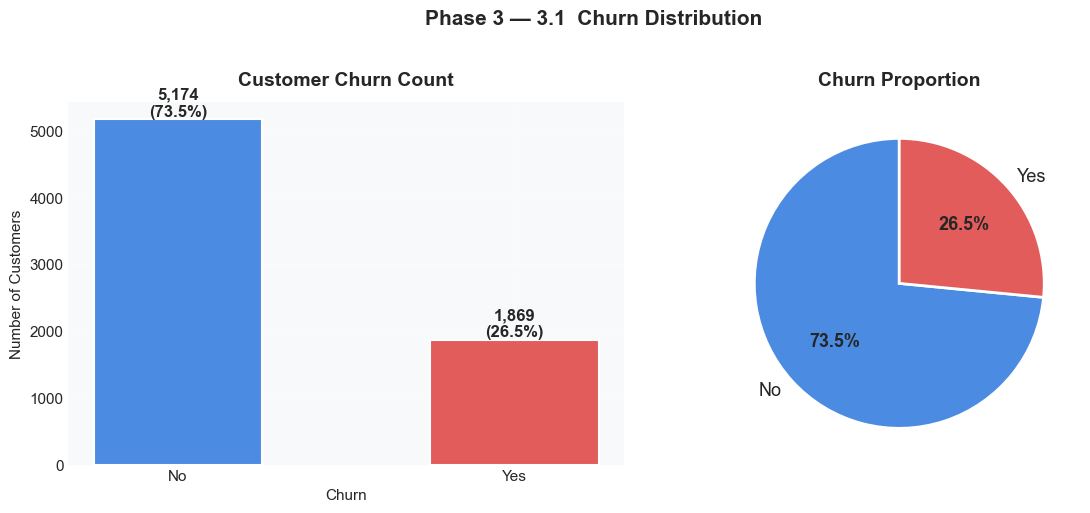

✅  Saved: phase3_3_1_churn_distribution.png


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

churn_counts = df_raw[TARGET].value_counts()
churn_pct    = df_raw[TARGET].value_counts(normalize=True) * 100

# Bar chart
bars = axes[0].bar(
    churn_counts.index, churn_counts.values,
    color=[C_NO, C_YES], edgecolor="white", linewidth=1.5, width=0.5
)
axes[0].set_title("Customer Churn Count", fontsize=14, fontweight="bold", pad=12)
axes[0].set_xlabel("Churn"); axes[0].set_ylabel("Number of Customers")
for bar in bars:
    h = bar.get_height()
    axes[0].annotate(f"{int(h):,}\n({h/len(df_raw)*100:.1f}%)",
                     (bar.get_x() + bar.get_width()/2, h),
                     ha="center", va="bottom", fontsize=12, fontweight="bold")

# Pie chart
wedges, texts, autotexts = axes[1].pie(
    churn_counts.values,
    labels=churn_counts.index,
    colors=[C_NO, C_YES],
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "white", "linewidth": 2},
    textprops={"fontsize": 13},
)
for at in autotexts:
    at.set_fontsize(13); at.set_fontweight("bold")
axes[1].set_title("Churn Proportion", fontsize=14, fontweight="bold", pad=12)

plt.suptitle("Phase 3 — 3.1  Churn Distribution", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("phase3_3_1_churn_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase3_3_1_churn_distribution.png")

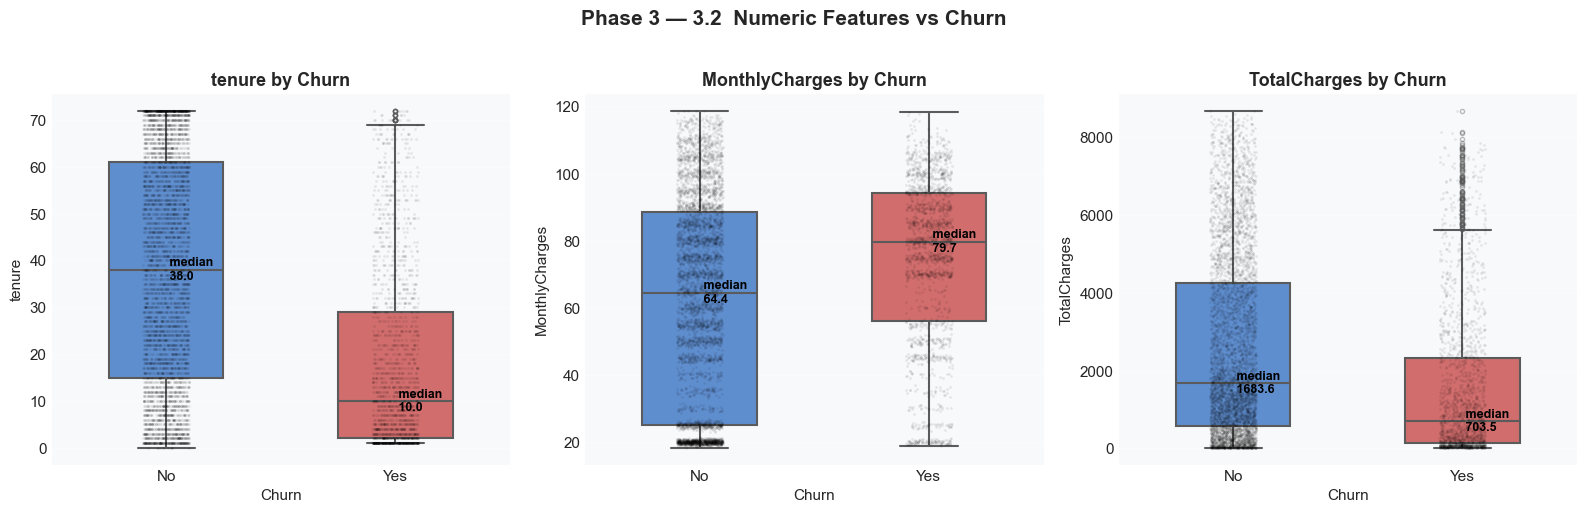

✅  Saved: phase3_3_2_numeric_vs_churn.png


In [36]:
NUMERIC_RAW = ["tenure", "MonthlyCharges", "TotalCharges"]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col in zip(axes, NUMERIC_RAW):
    df_plot = df_raw.copy()
    df_plot["TotalCharges"] = pd.to_numeric(df_plot["TotalCharges"], errors="coerce")
    
    sns.boxplot(
        data=df_plot, x=TARGET, y=col,
        palette={"No": C_NO, "Yes": C_YES},
        width=0.5, linewidth=1.5,
        flierprops={"marker": "o", "markersize": 3, "alpha": 0.4},
        ax=ax
    )
    # Overlay strip for density feel
    sns.stripplot(
        data=df_plot, x=TARGET, y=col,
        color="black", alpha=0.08, size=2, ax=ax
    )
    ax.set_title(f"{col} by Churn", fontweight="bold", fontsize=13)
    ax.set_xlabel("Churn"); ax.set_ylabel(col)
    
    # Annotate medians
    for i, grp in enumerate(["No", "Yes"]):
        med = df_plot[df_plot[TARGET] == grp][col].median()
        ax.text(i, med, f" median\n {med:.1f}",
                va="center", fontsize=9, color="black", fontweight="bold")

plt.suptitle("Phase 3 — 3.2  Numeric Features vs Churn", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("phase3_3_2_numeric_vs_churn.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase3_3_2_numeric_vs_churn.png")

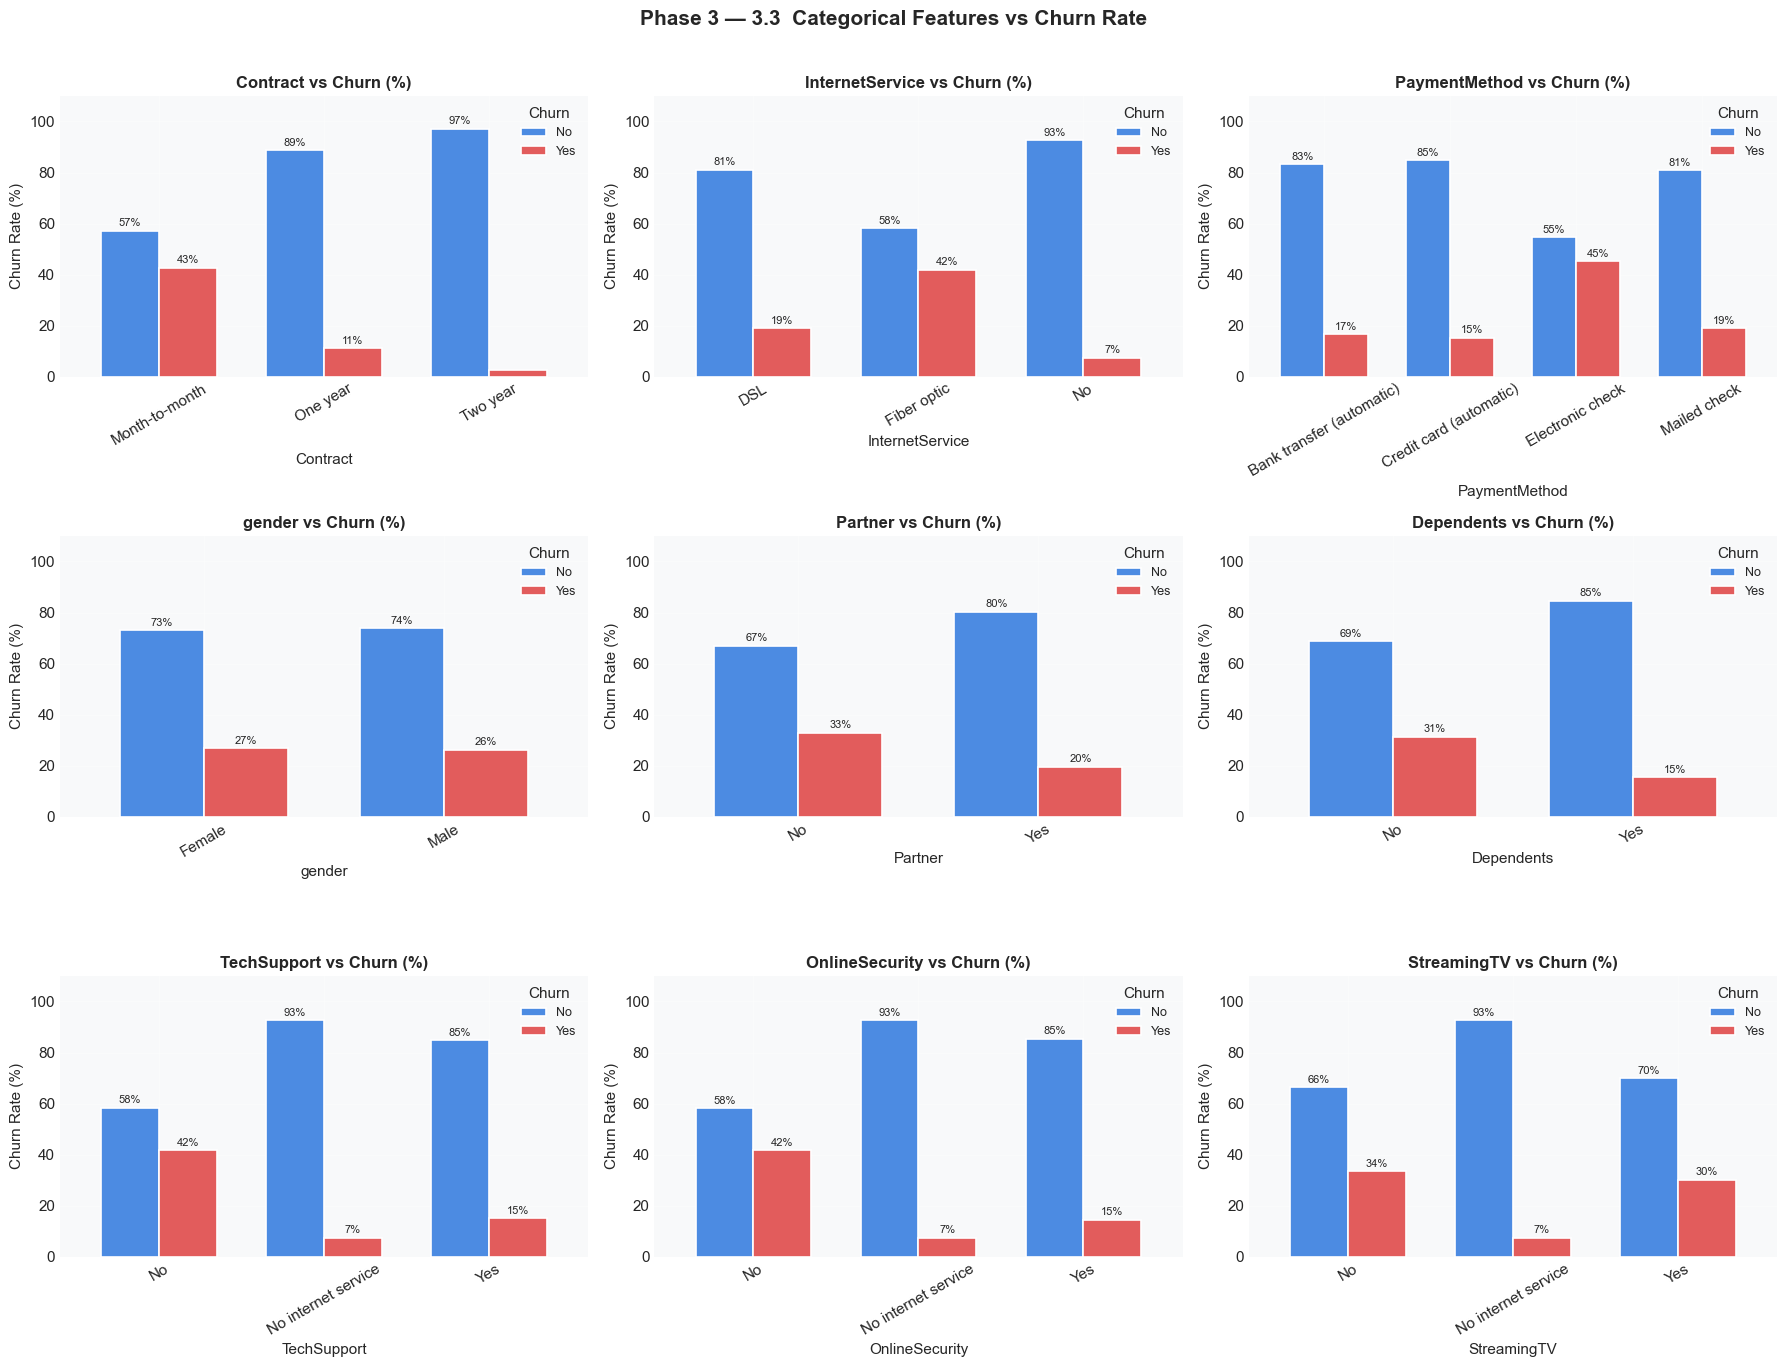

✅  Saved: phase3_3_3_categorical_vs_churn.png


In [37]:
CAT_COLS = [
    "Contract", "InternetService", "PaymentMethod",
    "gender", "Partner", "Dependents",
    "TechSupport", "OnlineSecurity", "StreamingTV"
]
# Use raw data (before encoding) for readable labels
CAT_COLS = [c for c in CAT_COLS if c in df_raw.columns]

ncols = 3
nrows = (len(CAT_COLS) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.5*nrows))
axes = axes.flatten()

for i, col in enumerate(CAT_COLS):
    ct = pd.crosstab(df_raw[col], df_raw[TARGET], normalize="index") * 100
    ct.plot(kind="bar", ax=axes[i],
            color=[C_NO, C_YES], edgecolor="white", linewidth=1.2, width=0.7)
    axes[i].set_title(f"{col} vs Churn (%)", fontweight="bold", fontsize=12)
    axes[i].set_xlabel(col); axes[i].set_ylabel("Churn Rate (%)")
    axes[i].tick_params(axis="x", rotation=30)
    axes[i].legend(title="Churn", labels=["No", "Yes"], fontsize=9)
    axes[i].set_ylim(0, 110)
    # Annotate bars
    for bar in axes[i].patches:
        h = bar.get_height()
        if h > 3:
            axes[i].annotate(f"{h:.0f}%",
                             (bar.get_x() + bar.get_width()/2, h + 1),
                             ha="center", va="bottom", fontsize=8)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Phase 3 — 3.3  Categorical Features vs Churn Rate",
             fontsize=15, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("phase3_3_3_categorical_vs_churn.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase3_3_3_categorical_vs_churn.png")

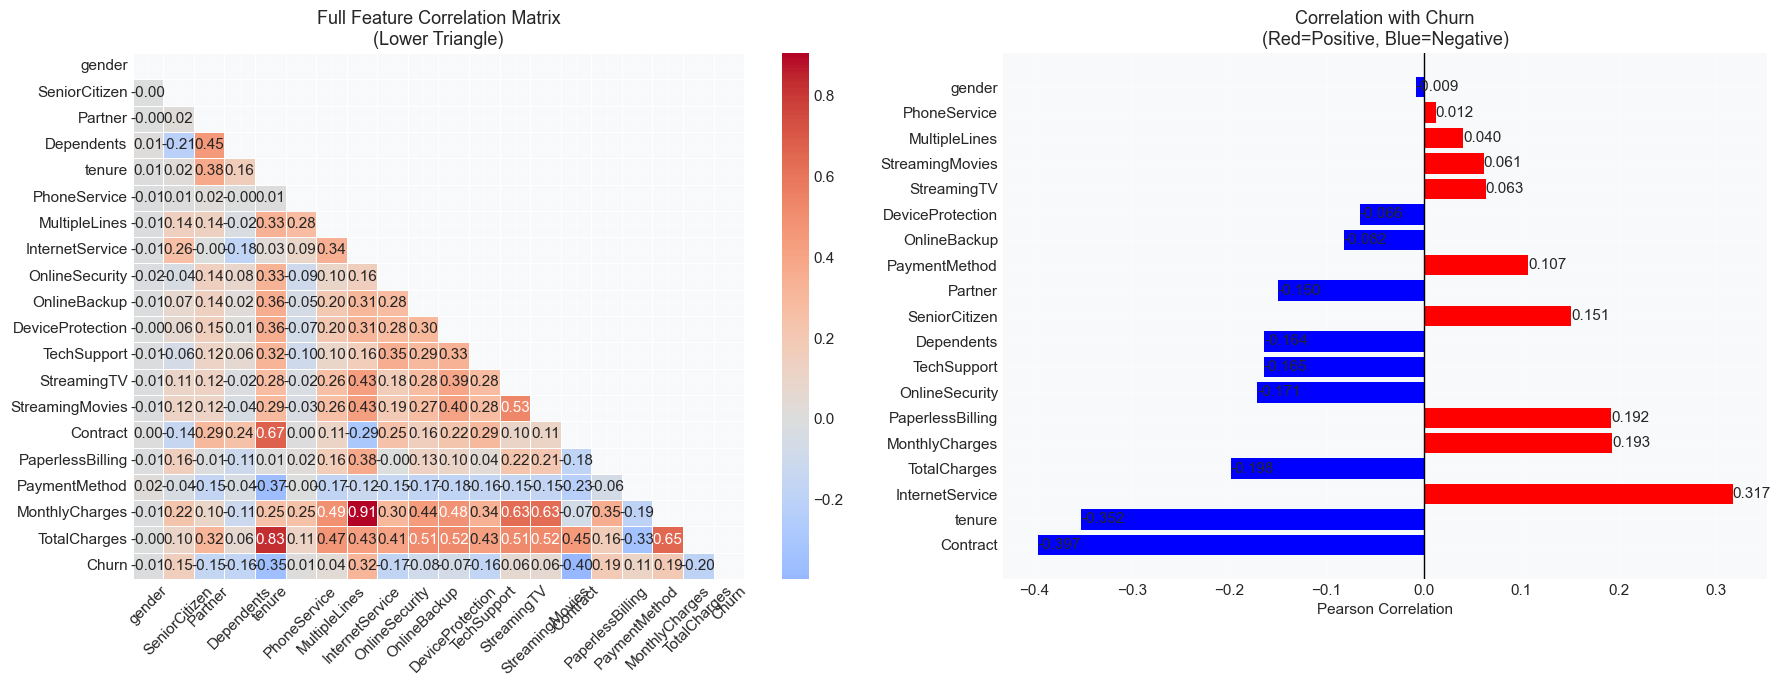

✅ Saved: correlation_analysis.png


In [39]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Correlation with target
target_corr = corr[TARGET].drop(TARGET).sort_values(key=abs, ascending=False)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ---------------------------
# 1️⃣ Full Correlation Heatmap
# ---------------------------
mask = np.triu(np.ones_like(corr, dtype=bool))  # mask upper triangle

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    ax=axes[0]
)

axes[0].set_title("Full Feature Correlation Matrix\n(Lower Triangle)", fontsize=13)
axes[0].tick_params(axis="x", rotation=45)

# ---------------------------
# 2️⃣ Correlation with Target
# ---------------------------
colors = ["red" if v > 0 else "blue" for v in target_corr.values]

axes[1].barh(target_corr.index, target_corr.values, color=colors)
axes[1].axvline(0, color="black", linewidth=1)
axes[1].set_title("Correlation with Churn\n(Red=Positive, Blue=Negative)", fontsize=13)
axes[1].set_xlabel("Pearson Correlation")

# Add value labels
for i, v in enumerate(target_corr.values):
    axes[1].text(v, i, f"{v:.3f}", va="center")

plt.tight_layout()
plt.savefig("correlation_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved: correlation_analysis.png")

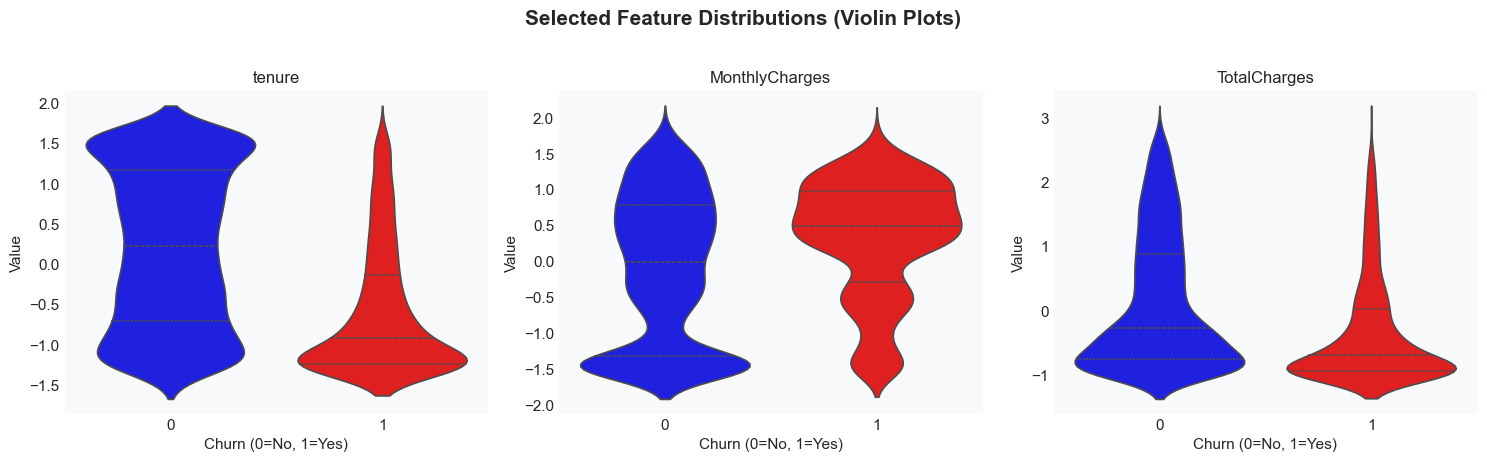

✅ Saved: violin_plots.png


In [41]:
C_NO = "blue"
C_YES = "red"

sel_numeric = [f for f in SELECTED_FEATURES if df[f].nunique() > 5]

if len(sel_numeric) == 0:
    print("No suitable numeric features found.")
else:
    ncols = min(4, len(sel_numeric))
    nrows = (len(sel_numeric) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows))
    axes = np.array(axes).flatten()

    for i, col in enumerate(sel_numeric):
        sns.violinplot(
            data=df,
            x=TARGET,
            y=col,
            palette=["blue", "red"],
            inner="quartile",
            linewidth=1.2,
            ax=axes[i]
        )
        axes[i].set_title(col, fontsize=12)
        axes[i].set_xlabel("Churn (0=No, 1=Yes)")
        axes[i].set_ylabel("Value")

    # Hide extra empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(
        "Selected Feature Distributions (Violin Plots)",
        fontsize=15,
        fontweight="bold",
        y=1.02
    )

    plt.tight_layout()

    # ✅ Save BEFORE show()
    plt.savefig("violin_plots.png", dpi=150, bbox_inches="tight")

    plt.show()

    print("✅ Saved: violin_plots.png")

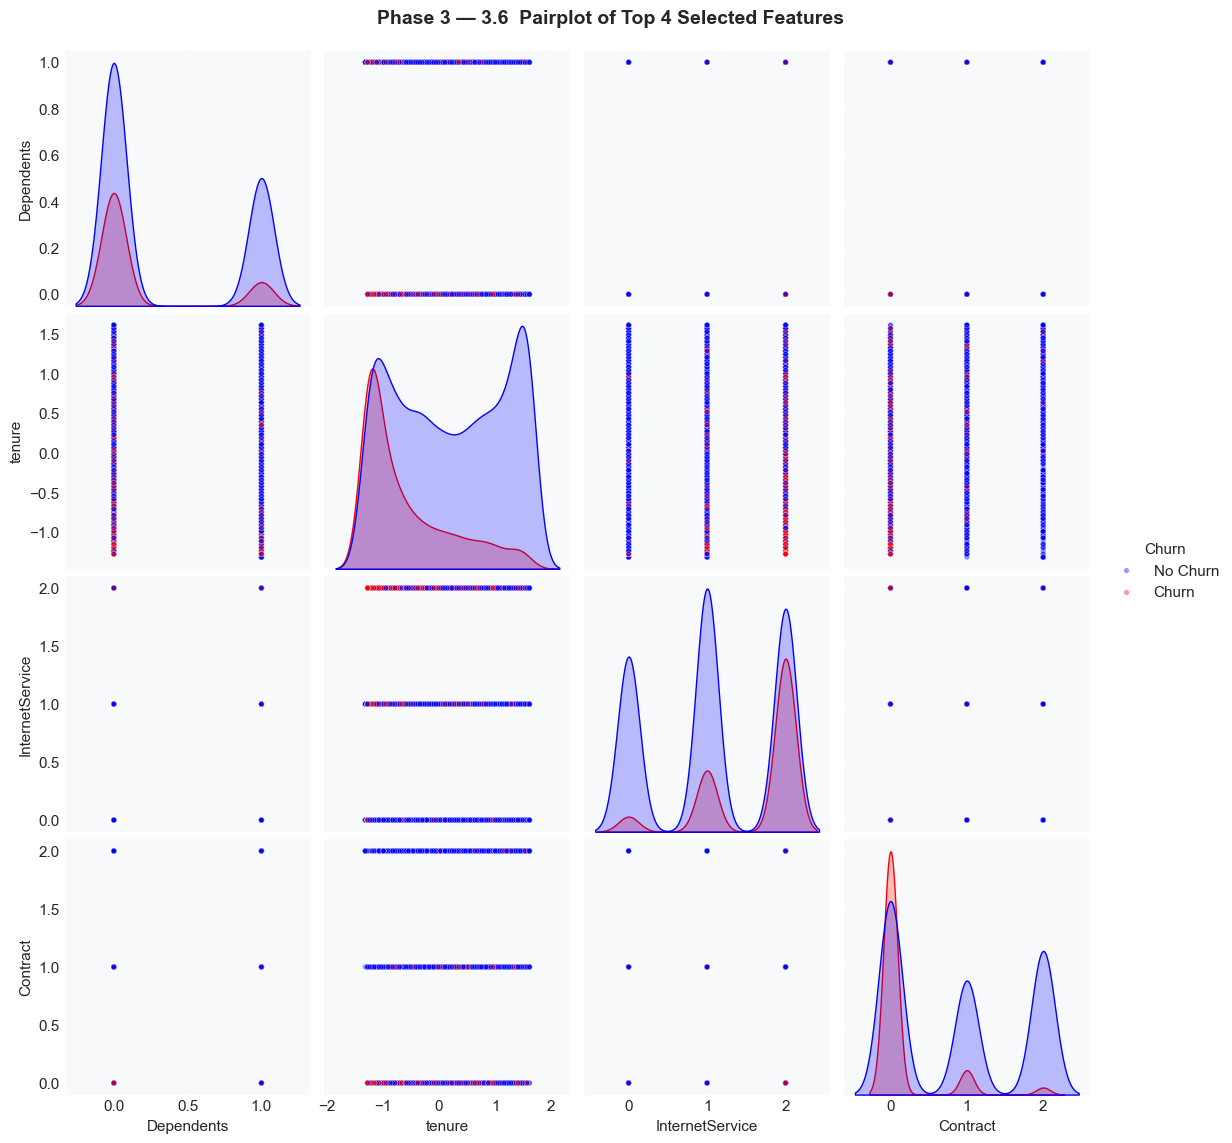

✅  Saved: phase3_3_6_pairplot.png


In [42]:
# Use top 4 MI-score features for readability
TOP4 = SELECTED_FEATURES[:4]

plot_df = df[TOP4 + [TARGET]].copy()
plot_df[TARGET] = plot_df[TARGET].map({0: "No Churn", 1: "Churn"})

g = sns.pairplot(
    plot_df, hue=TARGET,
    palette={"No Churn": C_NO, "Churn": C_YES},
    diag_kind="kde", plot_kws={"alpha": 0.4, "s": 15},
    height=2.8
)
g.figure.suptitle(
    "Phase 3 — 3.6  Pairplot of Top 4 Selected Features",
    fontsize=14, fontweight="bold", y=1.02
)
plt.savefig("phase3_3_6_pairplot.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase3_3_6_pairplot.png")

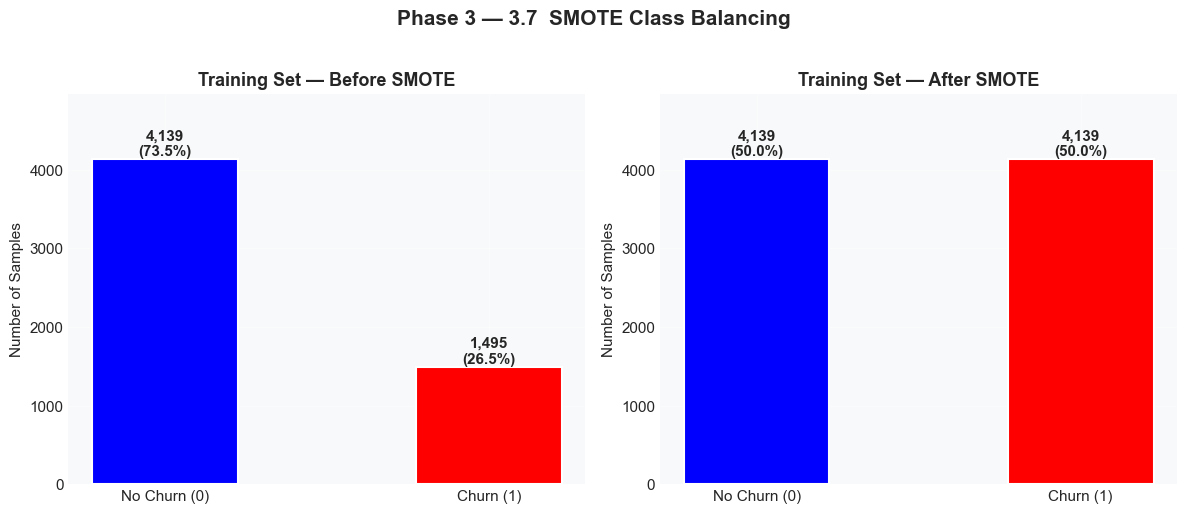

✅  Saved: phase3_3_7_smote_balance.png


In [43]:
X_all = df[SELECTED_FEATURES]
y_all = df[TARGET]
_, _, y_tr_orig, _ = train_test_split(X_all, y_all, test_size=0.2,
                                       random_state=42, stratify=y_all)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def plot_balance(ax, y, title):
    vc = pd.Series(y).value_counts().sort_index()
    labels = ["No Churn (0)", "Churn (1)"]
    colors = [C_NO, C_YES]
    bars = ax.bar(labels, vc.values, color=colors, edgecolor="white",
                  linewidth=1.5, width=0.45)
    ax.set_title(title, fontweight="bold", fontsize=13)
    ax.set_ylabel("Number of Samples")
    for bar, v in zip(bars, vc.values):
        ax.annotate(f"{v:,}\n({v/vc.sum()*100:.1f}%)",
                    (bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha="center", va="bottom", fontweight="bold", fontsize=11)
    ax.set_ylim(0, max(vc.values) * 1.2)

plot_balance(axes[0], y_tr_orig, "Training Set — Before SMOTE")
plot_balance(axes[1], y_train_sm, "Training Set — After SMOTE")

plt.suptitle("Phase 3 — 3.7  SMOTE Class Balancing", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("phase3_3_7_smote_balance.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase3_3_7_smote_balance.png")

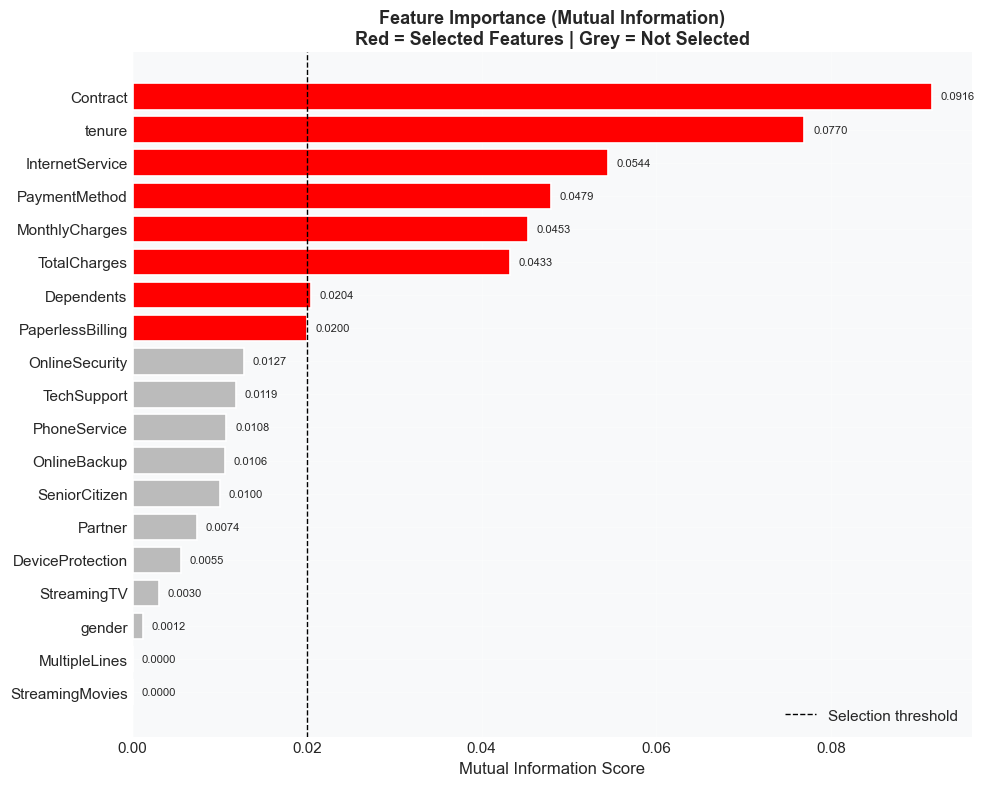

✅ Saved: feature_importance_mi.png


In [45]:
from sklearn.feature_selection import mutual_info_classif

# Ensure colors exist
C_YES = "red"

# Prepare data
X_all = df.drop(columns=[TARGET])
y_all = df[TARGET]

mi_scores = mutual_info_classif(X_all, y_all, random_state=42)

mi_df = pd.DataFrame({
    "Feature": X_all.columns,
    "MI Score": mi_scores
}).sort_values("MI Score", ascending=True)

# Highlight selected features
mi_df["Selected"] = mi_df["Feature"].isin(SELECTED_FEATURES)
colors = ["red" if sel else "#BBBBBB" for sel in mi_df["Selected"]]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(
    mi_df["Feature"],
    mi_df["MI Score"],
    color=colors,
    edgecolor="white",
    linewidth=1.2
)

# Optional threshold line (only if selected features exist)
if mi_df["Selected"].any():
    threshold = mi_df[mi_df["Selected"]]["MI Score"].min()
    ax.axvline(
        threshold,
        color="black",
        linestyle="--",
        linewidth=1,
        label="Selection threshold"
    )
    ax.legend()

ax.set_xlabel("Mutual Information Score", fontsize=12)

ax.set_title(
    "Feature Importance (Mutual Information)\n"
    "Red = Selected Features | Grey = Not Selected",
    fontweight="bold",
    fontsize=13
)

# Add value labels
for bar, val in zip(bars, mi_df["MI Score"]):
    ax.text(
        val + 0.001,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.4f}",
        va="center",
        fontsize=8
    )

plt.tight_layout()
plt.savefig("feature_importance_mi.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved: feature_importance_mi.png")

In [47]:
print("=" * 65)
print("VISUALIZATION COMPLETE")
print("=" * 65)
plots = [
    ("3.1", "Churn distribution (bar + pie)",              "churn_distribution.png"),
    ("3.2", "Numeric features vs churn (boxplots)",        "numeric_vs_churn.png"),
    ("3.3", "Categorical features vs churn (grouped bar)", "categorical_vs_churn.png"),
    ("3.4", "Full correlation heatmap + churn corr bar",   "correlation_heatmap.png"),
    ("3.5", "Selected features violin plots",              "violin_plots.png"),
    ("3.6", "Pairplot top 4 features",                     "pairplot.png"),
    ("3.7", "SMOTE class balance before vs after",         "smote_balance.png"),
    ("3.8", "Mutual information feature importance",       "feature_importance.png"),
]
for num, desc, fname in plots:
    print(f"  ✅  {num}  {desc}")
    print(f"       → saved as '{fname}'")

print()
print("  Key Insights:")
print("  → Month-to-month contracts have highest churn rate")
print("  → Fiber optic internet users churn more")
print("  → Higher tenure strongly associated with lower churn")
print("  → Electronic check payment method linked to higher churn")
print("=" * 65)

VISUALIZATION COMPLETE
  ✅  3.1  Churn distribution (bar + pie)
       → saved as 'churn_distribution.png'
  ✅  3.2  Numeric features vs churn (boxplots)
       → saved as 'numeric_vs_churn.png'
  ✅  3.3  Categorical features vs churn (grouped bar)
       → saved as 'categorical_vs_churn.png'
  ✅  3.4  Full correlation heatmap + churn corr bar
       → saved as 'correlation_heatmap.png'
  ✅  3.5  Selected features violin plots
       → saved as 'violin_plots.png'
  ✅  3.6  Pairplot top 4 features
       → saved as 'pairplot.png'
  ✅  3.7  SMOTE class balance before vs after
       → saved as 'smote_balance.png'
  ✅  3.8  Mutual information feature importance
       → saved as 'feature_importance.png'

  Key Insights:
  → Month-to-month contracts have highest churn rate
  → Fiber optic internet users churn more
  → Higher tenure strongly associated with lower churn
  → Electronic check payment method linked to higher churn


In [49]:
# Fit PCA with all components to see how variance distributes
pca_full = PCA(n_components=len(SELECTED_FEATURES), random_state=42)
pca_full.fit(X_train_sm)

explained_var      = pca_full.explained_variance_ratio_ * 100
cumulative_var     = np.cumsum(explained_var)
n_features         = len(SELECTED_FEATURES)

print("Explained Variance per Component:")
print(f"{'Component':<12} {'Individual %':<16} {'Cumulative %'}")
print("-" * 42)
for i, (ind, cum) in enumerate(zip(explained_var, cumulative_var)):
    marker = " ← 95% threshold" if cum >= 95 and (i == 0 or cumulative_var[i-1] < 95) else ""
    marker = " ← 90% threshold" if cum >= 90 and (i == 0 or cumulative_var[i-1] < 90) else marker
    print(f"  PC{i+1:<9} {ind:>8.2f}%        {cum:>8.2f}%{marker}")

Explained Variance per Component:
Component    Individual %     Cumulative %
------------------------------------------
  PC1            46.33%           46.33%
  PC2            26.33%           72.66%
  PC3            14.86%           87.52%
  PC4             4.05%           91.58% ← 90% threshold
  PC5             3.49%           95.06% ← 95% threshold
  PC6             3.07%           98.13%
  PC7             1.23%           99.36%
  PC8             0.64%          100.00%


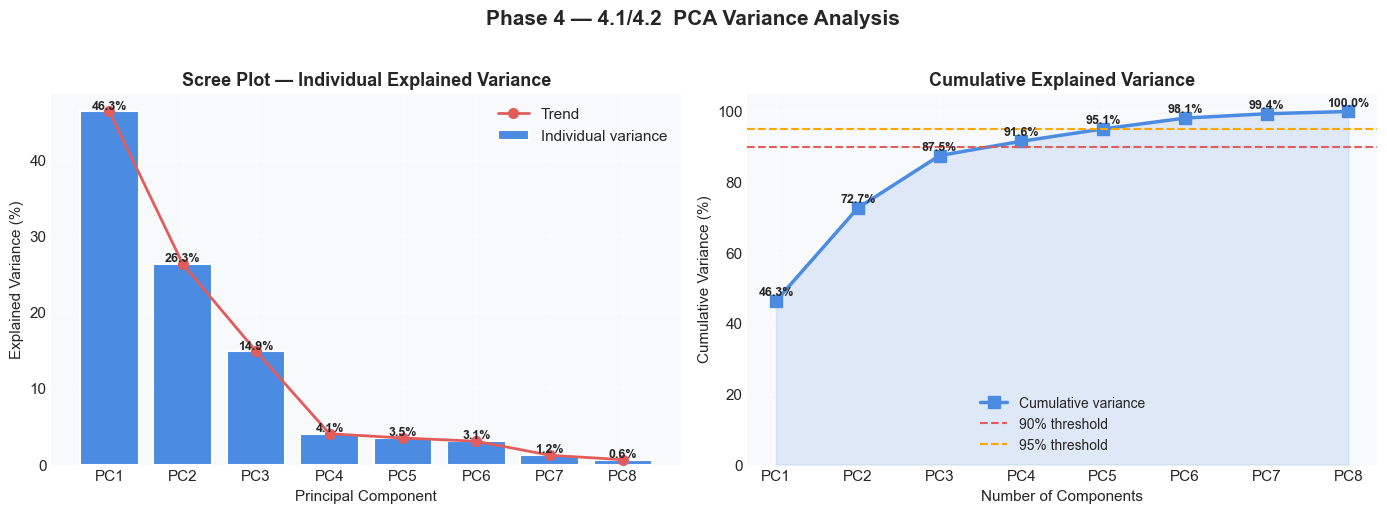

✅  Saved: phase4_4_2_scree_plot.png


In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
components = [f"PC{i+1}" for i in range(n_features)]

# Scree plot
axes[0].bar(components, explained_var, color="#4C8BE2", edgecolor="white",
            linewidth=1.5, label="Individual variance")
axes[0].plot(components, explained_var, "o-", color="#E25C5C",
             linewidth=2, markersize=7, label="Trend")
axes[0].set_title("Scree Plot — Individual Explained Variance",
                  fontweight="bold", fontsize=13)
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance (%)")
axes[0].legend()
for i, v in enumerate(explained_var):
    axes[0].text(i, v + 0.3, f"{v:.1f}%", ha="center", fontsize=9, fontweight="bold")

# Cumulative variance
axes[1].plot(components, cumulative_var, "s-", color="#4C8BE2",
             linewidth=2.5, markersize=8, label="Cumulative variance")
axes[1].axhline(90, color="#E25C5C", linestyle="--", linewidth=1.5, label="90% threshold")
axes[1].axhline(95, color="orange",  linestyle="--", linewidth=1.5, label="95% threshold")
axes[1].fill_between(range(n_features), cumulative_var, alpha=0.15, color="#4C8BE2")
axes[1].set_xticks(range(n_features)); axes[1].set_xticklabels(components)
axes[1].set_title("Cumulative Explained Variance",
                  fontweight="bold", fontsize=13)
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Variance (%)")
axes[1].set_ylim(0, 105)
axes[1].legend(fontsize=10)
for i, v in enumerate(cumulative_var):
    axes[1].text(i, v + 1.5, f"{v:.1f}%", ha="center", fontsize=9, fontweight="bold")

plt.suptitle("Phase 4 — 4.1/4.2  PCA Variance Analysis",
             fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("phase4_4_2_scree_plot.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase4_4_2_scree_plot.png")

In [51]:
N_COMPONENTS = 4   # Used for VQC in Phase 5

# How much variance does our choice capture?
var_captured = cumulative_var[N_COMPONENTS - 1]
print(f"✅  Selected N_COMPONENTS = {N_COMPONENTS}")
print(f"   Variance captured      : {var_captured:.2f}%")
print(f"   Variance lost          : {100 - var_captured:.2f}%")
print()
print("   Rationale:")
print("   → ZZFeatureMap encodes n features into n qubits")
print(f"   → {N_COMPONENTS} qubits = manageable circuit depth for simulation")
print(f"   → {var_captured:.1f}% variance retained is sufficient for classification")

✅  Selected N_COMPONENTS = 4
   Variance captured      : 91.58%
   Variance lost          : 8.42%

   Rationale:
   → ZZFeatureMap encodes n features into n qubits
   → 4 qubits = manageable circuit depth for simulation
   → 91.6% variance retained is sufficient for classification


In [52]:
pca = PCA(n_components=N_COMPONENTS, random_state=42)
X_train_pca = pca.fit_transform(X_train_sm)
X_test_pca  = pca.transform(X_test)

print(f"✅  PCA fitted on training data")
print(f"   X_train_pca shape : {X_train_pca.shape}")
print(f"   X_test_pca shape  : {X_test_pca.shape}")

# Component column names
PCA_COLS = [f"PC{i+1}" for i in range(N_COMPONENTS)]

# DataFrames for easy plotting
train_pca_df          = pd.DataFrame(X_train_pca, columns=PCA_COLS)
train_pca_df["Churn"] = y_train_sm.values
test_pca_df           = pd.DataFrame(X_test_pca,  columns=PCA_COLS)
test_pca_df["Churn"]  = y_test.values

print(f"\n   Explained variance per component:")
for i, v in enumerate(pca.explained_variance_ratio_ * 100):
    print(f"   PC{i+1}: {v:.2f}%")

✅  PCA fitted on training data
   X_train_pca shape : (8278, 4)
   X_test_pca shape  : (1409, 4)

   Explained variance per component:
   PC1: 46.33%
   PC2: 26.33%
   PC3: 14.86%
   PC4: 4.05%


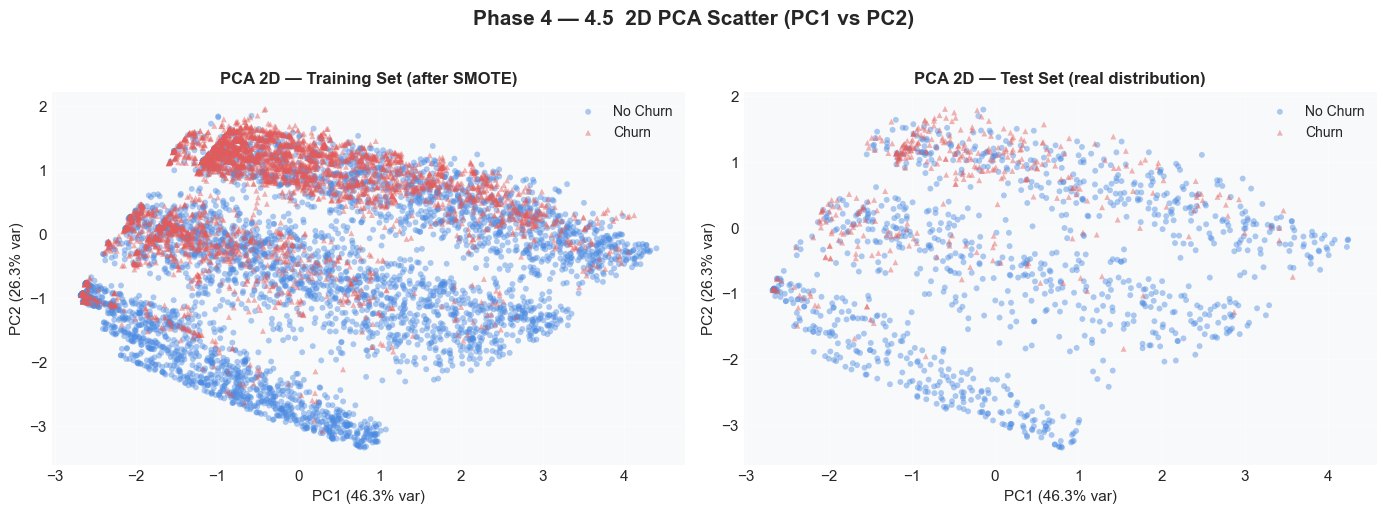

✅  Saved: phase4_4_5_pca_2d_scatter.png


In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (df_p, title) in zip(axes, [
    (train_pca_df, "Training Set (after SMOTE)"),
    (test_pca_df,  "Test Set (real distribution)"),
]):
    for label, color, marker in [(0, C_NO, "o"), (1, C_YES, "^")]:
        mask = df_p["Churn"] == label
        ax.scatter(
            df_p.loc[mask, "PC1"], df_p.loc[mask, "PC2"],
            c=color, label=f"{'No Churn' if label==0 else 'Churn'}",
            alpha=0.45, s=18, marker=marker, edgecolors="none"
        )
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)", fontsize=11)
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)", fontsize=11)
    ax.set_title(f"PCA 2D — {title}", fontweight="bold", fontsize=12)
    ax.legend(fontsize=10)

plt.suptitle("Phase 4 — 4.5  2D PCA Scatter (PC1 vs PC2)",
             fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("phase4_4_5_pca_2d_scatter.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase4_4_5_pca_2d_scatter.png")


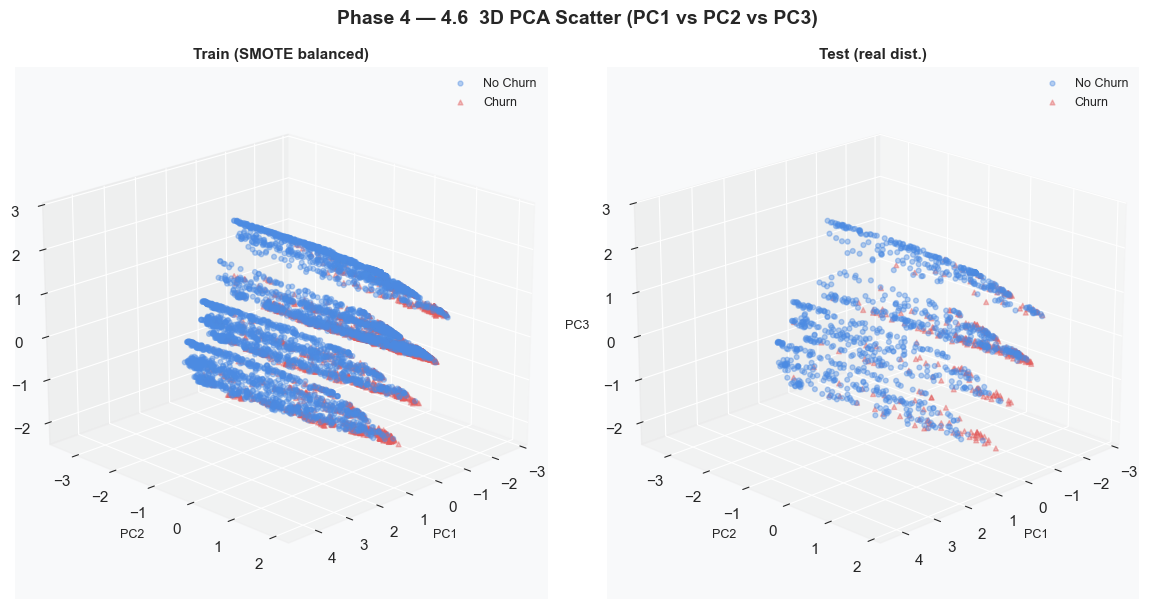

✅  Saved: phase4_4_6_pca_3d_scatter.png


In [54]:
fig = plt.figure(figsize=(12, 6))

for idx, (df_p, title) in enumerate([
    (train_pca_df, "Train (SMOTE balanced)"),
    (test_pca_df,  "Test (real dist.)"),
]):
    ax = fig.add_subplot(1, 2, idx+1, projection="3d")
    for label, color, marker in [(0, C_NO, "o"), (1, C_YES, "^")]:
        mask = df_p["Churn"] == label
        ax.scatter(
            df_p.loc[mask, "PC1"],
            df_p.loc[mask, "PC2"],
            df_p.loc[mask, "PC3"],
            c=color, label=f"{'No Churn' if label==0 else 'Churn'}",
            alpha=0.4, s=12, marker=marker
        )
    ax.set_xlabel("PC1", fontsize=9); ax.set_ylabel("PC2", fontsize=9)
    ax.set_zlabel("PC3", fontsize=9)
    ax.set_title(title, fontweight="bold", fontsize=11)
    ax.legend(fontsize=9)
    ax.view_init(elev=20, azim=45)

plt.suptitle("Phase 4 — 4.6  3D PCA Scatter (PC1 vs PC2 vs PC3)",
             fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("phase4_4_6_pca_3d_scatter.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase4_4_6_pca_3d_scatter.png")


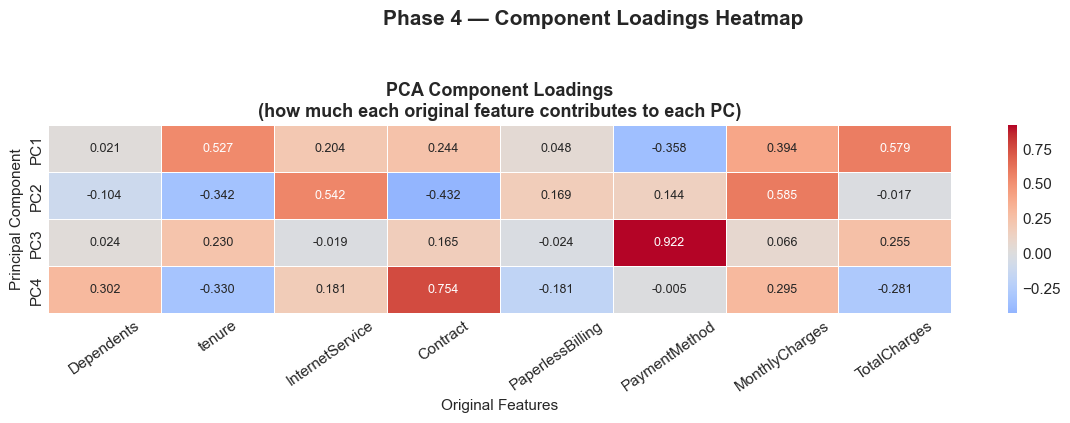

✅  Saved: phase4_loadings_heatmap.png

Interpretation — top 3 features per component:
  PC1: TotalCharges (+0.579), tenure (+0.527), MonthlyCharges (+0.394)
  PC2: MonthlyCharges (+0.585), InternetService (+0.542), Contract (-0.432)
  PC3: PaymentMethod (+0.922), TotalCharges (+0.255), tenure (+0.230)
  PC4: Contract (+0.754), tenure (-0.330), Dependents (+0.302)


In [56]:
feature_names = X_train_sm.columns.tolist()

loadings = pd.DataFrame(
    pca.components_,
    columns=feature_names,
    index=[f"PC{i+1}" for i in range(N_COMPONENTS)]
)

fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(
    loadings, annot=True, fmt=".3f", cmap="coolwarm",
    center=0, linewidths=0.5, linecolor="white",
    annot_kws={"size": 9}, ax=ax
)
ax.set_title("PCA Component Loadings\n(how much each original feature contributes to each PC)",
             fontweight="bold", fontsize=13)
ax.set_xlabel("Original Features")
ax.set_ylabel("Principal Component")
ax.tick_params(axis="x", rotation=35)

plt.suptitle("Phase 4 — Component Loadings Heatmap",
             fontsize=15, fontweight="bold", y=1.05)
plt.tight_layout()
plt.savefig("phase4_loadings_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅  Saved: phase4_loadings_heatmap.png")
print()
print("Interpretation — top 3 features per component:")
for pc in loadings.index:
    top = loadings.loc[pc].abs().nlargest(3)
    print(f"  {pc}: {', '.join([f'{f} ({loadings.loc[pc, f]:+.3f})' for f in top.index])}")

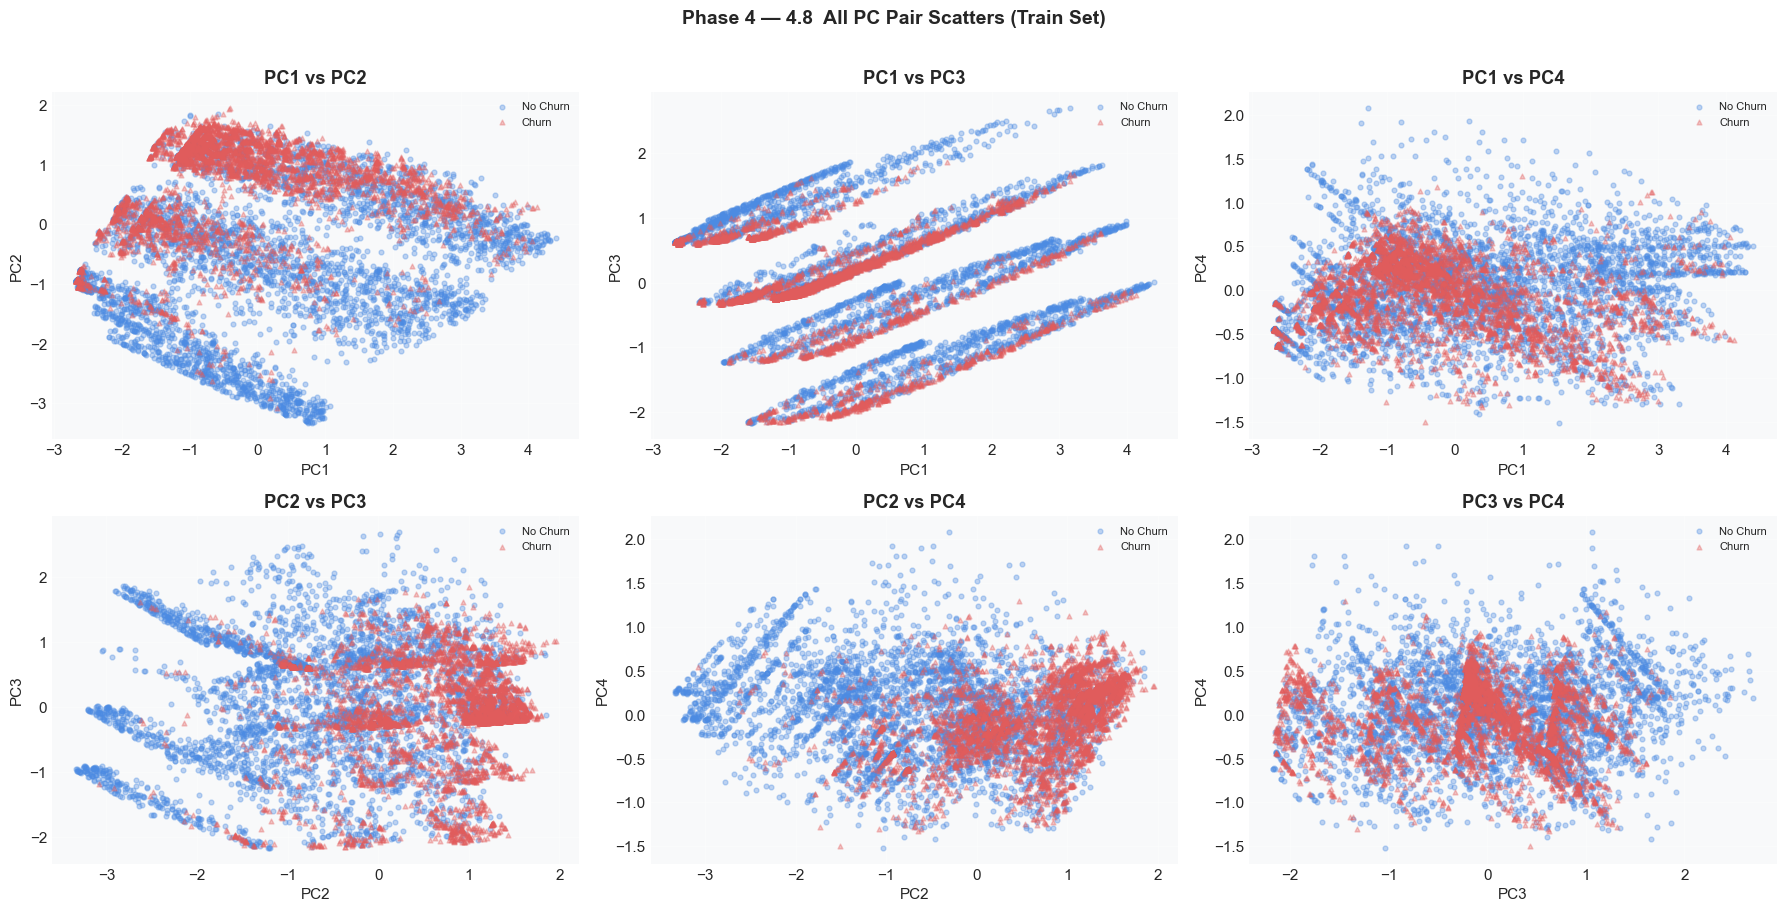

✅  Saved: phase4_4_8_pc_pairs.png


In [57]:
from itertools import combinations

pairs = list(combinations(PCA_COLS, 2))
ncols = 3
nrows = (len(pairs) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.5*nrows))
axes = axes.flatten()

for i, (pcx, pcy) in enumerate(pairs):
    for label, color, marker in [(0, C_NO, "o"), (1, C_YES, "^")]:
        mask = train_pca_df["Churn"] == label
        axes[i].scatter(
            train_pca_df.loc[mask, pcx],
            train_pca_df.loc[mask, pcy],
            c=color, alpha=0.35, s=12, marker=marker,
            label=f"{'No Churn' if label==0 else 'Churn'}"
        )
    axes[i].set_xlabel(pcx); axes[i].set_ylabel(pcy)
    axes[i].set_title(f"{pcx} vs {pcy}", fontweight="bold")
    axes[i].legend(fontsize=8)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Phase 4 — 4.8  All PC Pair Scatters (Train Set)",
             fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("phase4_4_8_pc_pairs.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase4_4_8_pc_pairs.png")

In [58]:
# Save as numpy arrays — Phase 5 VQC will load these
np.save("X_train_pca.npy", X_train_pca)
np.save("X_test_pca.npy",  X_test_pca)
np.save("y_train_sm.npy",  y_train_sm.values)
np.save("y_test.npy",      y_test.values)

print("✅  Saved PCA arrays to disk:")
print(f"   X_train_pca.npy  — shape {X_train_pca.shape}")
print(f"   X_test_pca.npy   — shape {X_test_pca.shape}")
print(f"   y_train_sm.npy   — shape {y_train_sm.shape}")
print(f"   y_test.npy       — shape {y_test.shape}")
print()
print("   In-memory variables ready for Phase 5:")
print("   → pca           fitted PCA object")
print("   → X_train_pca   (n_train, 4) training features")
print("   → X_test_pca    (n_test,  4) test features")
print("   → N_COMPONENTS  = 4  (number of qubits for VQC)")

✅  Saved PCA arrays to disk:
   X_train_pca.npy  — shape (8278, 4)
   X_test_pca.npy   — shape (1409, 4)
   y_train_sm.npy   — shape (8278,)
   y_test.npy       — shape (1409,)

   In-memory variables ready for Phase 5:
   → pca           fitted PCA object
   → X_train_pca   (n_train, 4) training features
   → X_test_pca    (n_test,  4) test features
   → N_COMPONENTS  = 4  (number of qubits for VQC)


In [59]:
print("=" * 65)
print("PCA DIMENSIONALITY REDUCTION COMPLETE")
print("=" * 65)
print(f"  Input features          : {len(SELECTED_FEATURES)}  ({SELECTED_FEATURES})")
print(f"  PCA components chosen   : {N_COMPONENTS}")
print(f"  Variance retained       : {cumulative_var[N_COMPONENTS-1]:.2f}%")
print(f"  X_train_pca shape       : {X_train_pca.shape}")
print(f"  X_test_pca  shape       : {X_test_pca.shape}")
print()
print("  Plots saved:")
plots = [
    "scree_plot.png",
    "pca_2d_scatter.png",
    "pca_3d_scatter.png",
    "loadings_heatmap.png",
    "pc_pairs.png",
]
for p in plots:
    print(f"  ✅  {p}")
print()
print("  Why PCA matters for VQC:")
print("  → Each PC becomes 1 qubit in ZZFeatureMap")
print(f"  → {N_COMPONENTS} qubits = O({N_COMPONENTS}²)={N_COMPONENTS**2} gates per layer (feasible)")
print("  → Without PCA, 8 features = 64 gates/layer (too slow to simulate)")
print()
print("=" * 65)

PCA DIMENSIONALITY REDUCTION COMPLETE
  Input features          : 8  (['Dependents', 'tenure', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges'])
  PCA components chosen   : 4
  Variance retained       : 91.58%
  X_train_pca shape       : (8278, 4)
  X_test_pca  shape       : (1409, 4)

  Plots saved:
  ✅  scree_plot.png
  ✅  pca_2d_scatter.png
  ✅  pca_3d_scatter.png
  ✅  loadings_heatmap.png
  ✅  pc_pairs.png

  Why PCA matters for VQC:
  → Each PC becomes 1 qubit in ZZFeatureMap
  → 4 qubits = O(4²)=16 gates per layer (feasible)
  → Without PCA, 8 features = 64 gates/layer (too slow to simulate)



In [71]:
from sklearn.utils import resample

N_SAMPLES = 2200 
y_tr = y_train_sm.values if hasattr(y_train_sm, "values") else y_train_sm

idx_0 = np.where(y_tr == 0)[0]
idx_1 = np.where(y_tr == 1)[0]

rng = np.random.default_rng(SEED)
sel_0 = rng.choice(idx_0, size=N_SAMPLES // 2, replace=False)
sel_1 = rng.choice(idx_1, size=N_SAMPLES // 2, replace=False)
sel   = np.concatenate([sel_0, sel_1])
rng.shuffle(sel)

X_vqc_train = X_train_pca[sel]
y_vqc_train = y_tr[sel]

# Full test set for evaluation
X_vqc_test = X_test_pca
y_vqc_test  = y_test.values if hasattr(y_test, "values") else y_test

print(f"✅  VQC training subset : {X_vqc_train.shape}  (balanced: {(y_vqc_train==0).sum()} vs {(y_vqc_train==1).sum()})")
print(f"   VQC test set        : {X_vqc_test.shape}")

✅  VQC training subset : (2200, 4)  (balanced: 1100 vs 1100)
   VQC test set        : (1409, 4)


In [72]:
n_qubits = N_COMPONENTS   # 4 qubits = 4 PCA components

# Feature map: encodes input data into quantum state
feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2)

# Ansatz: parameterized circuit that gets optimized during training
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=3)

print(f"✅  Quantum circuit built")
print(f"   Qubits         : {n_qubits}")
print(f"   Feature map    : ZZFeatureMap  (reps=2,  depth={feature_map.decompose().depth()})")
print(f"   Ansatz         : RealAmplitudes (reps=3, params={ansatz.num_parameters})")

# Draw the feature map
print("\n── Feature Map Circuit ──")
print(feature_map.decompose().draw(output="text", fold=80))
# Draw the ansatz
print("── Ansatz Circuit ──")
print(ansatz.draw(output="text", fold=80))

✅  Quantum circuit built
   Qubits         : 4
   Feature map    : ZZFeatureMap  (reps=2,  depth=31)
   Ansatz         : RealAmplitudes (reps=3, params=16)

── Feature Map Circuit ──
     ┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«                                                    »
«q_0: ──────────────────────────────────■─────────■──»
«                                       │

In [73]:
try:
    from qiskit_aer.primitives import Sampler as AerSampler
    AerSampler()  # test it works
except Exception:
    from qiskit_aer.primitives import StatevectorSampler as AerSampler

In [74]:
# Track loss during training
objective_values = []

def callback(weights, obj_val):
    objective_values.append(obj_val)
    if len(objective_values) % 10 == 0:
        print(f"   Iteration {len(objective_values):>4}  |  Loss: {obj_val:.4f}")

print("🚀  Starting VQC training...")
print(f"   Samples  : {N_SAMPLES} | Qubits: {n_qubits} | Max iterations: 500")
print("-" * 50)

sampler = AerSampler(run_options={"shots": 2048})

optimizer = COBYLA(maxiter=700)

ansatz = RealAmplitudes(num_qubits=n_qubits, reps=5)

vqc = VQC(
    sampler     = sampler,
    feature_map = feature_map,
    ansatz      = ansatz,
    optimizer   = optimizer,
    callback    = callback,
)

vqc.fit(X_vqc_train, y_vqc_train)

print("-" * 50)
print(f"✅  VQC training complete  ({len(objective_values)} iterations)")

🚀  Starting VQC training...
   Samples  : 2200 | Qubits: 4 | Max iterations: 500
--------------------------------------------------
   Iteration   10  |  Loss: 1.0324
   Iteration   20  |  Loss: 1.0099
   Iteration   30  |  Loss: 0.9950
   Iteration   40  |  Loss: 0.9999
   Iteration   50  |  Loss: 0.9839
   Iteration   60  |  Loss: 0.9787
   Iteration   70  |  Loss: 0.9735
   Iteration   80  |  Loss: 0.9730
   Iteration   90  |  Loss: 0.9715
   Iteration  100  |  Loss: 0.9687
   Iteration  110  |  Loss: 0.9688
   Iteration  120  |  Loss: 0.9695
   Iteration  130  |  Loss: 0.9686
   Iteration  140  |  Loss: 0.9689
   Iteration  150  |  Loss: 0.9689
   Iteration  160  |  Loss: 0.9683
   Iteration  170  |  Loss: 0.9688
   Iteration  180  |  Loss: 0.9698
   Iteration  190  |  Loss: 0.9694
   Iteration  200  |  Loss: 0.9690
   Iteration  210  |  Loss: 0.9697
   Iteration  220  |  Loss: 0.9686
   Iteration  230  |  Loss: 0.9694
   Iteration  240  |  Loss: 0.9690
----------------------------

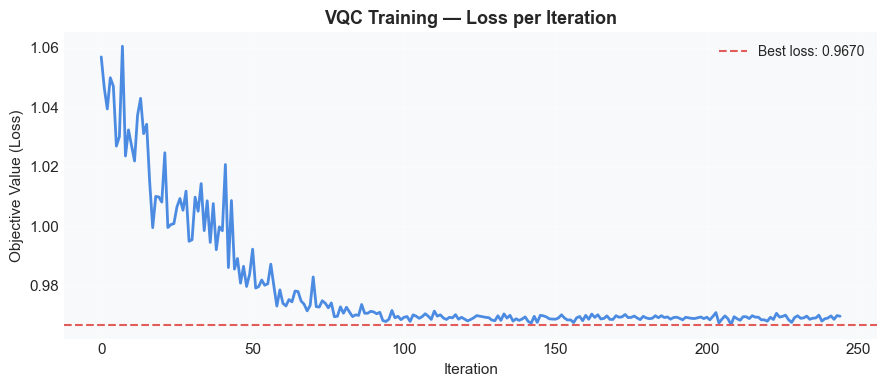

✅  Saved: phase5_vqc_loss_curve.png


In [75]:
plt.figure(figsize=(9, 4))
plt.plot(objective_values, color="#4C8BE2", linewidth=2)
plt.title("VQC Training — Loss per Iteration", fontweight="bold", fontsize=13)
plt.xlabel("Iteration"); plt.ylabel("Objective Value (Loss)")
plt.axhline(min(objective_values), color="#E25C5C", linestyle="--",
            linewidth=1.5, label=f"Best loss: {min(objective_values):.4f}")
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("phase5_vqc_loss_curve.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase5_vqc_loss_curve.png")

In [76]:
y_pred_vqc = vqc.predict(X_vqc_test)
vqc_acc    = accuracy_score(y_vqc_test, y_pred_vqc)

print(f"✅  VQC Test Accuracy: {vqc_acc*100:.2f}%")
print()
print("Classification Report — VQC:")
print(classification_report(y_vqc_test, y_pred_vqc,
                             target_names=["No Churn", "Churn"]))

✅  VQC Test Accuracy: 53.73%

Classification Report — VQC:
              precision    recall  f1-score   support

    No Churn       0.79      0.51      0.62      1035
       Churn       0.31      0.61      0.41       374

    accuracy                           0.54      1409
   macro avg       0.55      0.56      0.52      1409
weighted avg       0.66      0.54      0.56      1409



In [77]:
y_tr_full = y_train_sm.values if hasattr(y_train_sm, "values") else y_train_sm

classifiers = {
    "Logistic Regression" : LogisticRegression(random_state=SEED, max_iter=1000),
    "SVM (RBF kernel)"    : SVC(kernel="rbf", random_state=SEED, probability=True),
    "Random Forest"       : RandomForestClassifier(n_estimators=100, random_state=SEED),
}

results = {}
print(f"{'Model':<25} {'Accuracy':>10}")
print("-" * 38)

for name, clf in classifiers.items():
    clf.fit(X_train_pca, y_tr_full)
    y_pred = clf.predict(X_test_pca)
    acc    = accuracy_score(y_vqc_test, y_pred)
    results[name] = {"model": clf, "predictions": y_pred, "accuracy": acc}
    print(f"  {name:<23} {acc*100:>8.2f}%")

results["VQC"] = {"predictions": y_pred_vqc, "accuracy": vqc_acc}
print(f"  {'VQC':<23} {vqc_acc*100:>8.2f}%")
print()
print("✅  All models trained and evaluated")

Model                       Accuracy
--------------------------------------
  Logistic Regression        71.97%
  SVM (RBF kernel)           72.68%
  Random Forest              73.81%
  VQC                        53.73%

✅  All models trained and evaluated


In [80]:
# Test Random Forest on FULL features (not PCA) as a sanity check
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_train_sm, y_train_sm)
y_pred_full = rf_full.predict(X_test)

print("Random Forest on FULL features (no PCA):")
print(classification_report(y_test, y_pred_full, target_names=["No Churn", "Churn"]))

Random Forest on FULL features (no PCA):
              precision    recall  f1-score   support

    No Churn       0.85      0.80      0.82      1035
       Churn       0.52      0.60      0.56       374

    accuracy                           0.75      1409
   macro avg       0.68      0.70      0.69      1409
weighted avg       0.76      0.75      0.75      1409



✅  Random Forest (No PCA): 74.73%


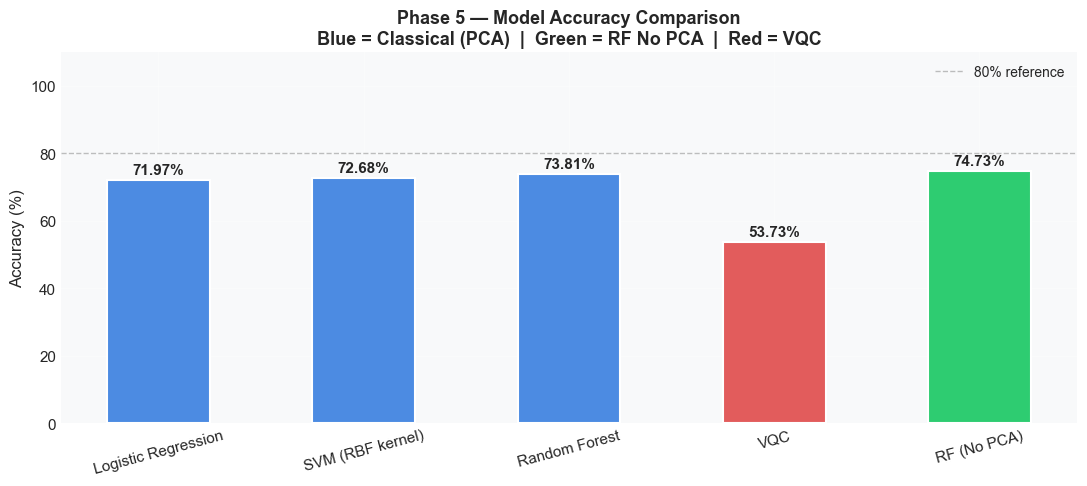

✅  Saved: phase5_accuracy_comparison.png


In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train Random Forest on full data WITHOUT PCA
y_tr_full = y_train_sm.values if hasattr(y_train_sm, "values") else y_train_sm
y_te      = y_test.values if hasattr(y_test, "values") else y_test

rf_no_pca = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_no_pca.fit(X_train_sm, y_tr_full)
y_pred_rf_nopca = rf_no_pca.predict(X_test)
acc_rf_nopca    = accuracy_score(y_te, y_pred_rf_nopca)

results["RF (No PCA)"] = {"predictions": y_pred_rf_nopca, "accuracy": acc_rf_nopca}
print(f"✅  Random Forest (No PCA): {acc_rf_nopca*100:.2f}%")

# ── Plot ──────────────────────────────────────────────────
names  = list(results.keys())
accs   = [results[n]["accuracy"] * 100 for n in names]

# Blue = classical with PCA, Green = RF no PCA, Red = VQC
colors = ["#4C8BE2", "#4C8BE2", "#4C8BE2", "#E25C5C", "#2ECC71"]

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.bar(names, accs, color=colors, edgecolor="white",
              linewidth=1.5, width=0.5)
ax.set_ylim(0, 110)
ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_title("Phase 5 — Model Accuracy Comparison\n"
             "Blue = Classical (PCA)  |  Green = RF No PCA  |  Red = VQC",
             fontweight="bold", fontsize=13)
ax.tick_params(axis="x", rotation=15)
ax.axhline(80, color="gray", linestyle="--", linewidth=1, alpha=0.5, label="80% reference")
ax.legend(fontsize=10)

for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{acc:.2f}%", ha="center", va="bottom",
            fontweight="bold", fontsize=11)

plt.tight_layout()
plt.savefig("phase5_accuracy_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase5_accuracy_comparison.png")

In [83]:
!pip install jinja2

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

y_true = y_vqc_test

metrics_data = []

for name, res in results.items():
    # If your results dict already contains predictions directly,
    # replace `res["predictions"]` with just `res`
    y_pred = res["predictions"]

    metrics_data.append({
        "Model": name,
        "Accuracy (%)": accuracy_score(y_true, y_pred) * 100,
        "Precision (%)": precision_score(y_true, y_pred, zero_division=0) * 100,
        "Recall (%)": recall_score(y_true, y_pred, zero_division=0) * 100,
        "F1 Score (%)": f1_score(y_true, y_pred, zero_division=0) * 100,
    })

metrics_df = pd.DataFrame(metrics_data).set_index("Model").round(2)

print("Full Evaluation Metrics (%):")
display(metrics_df)

Full Evaluation Metrics (%):


,Accuracy (%),Precision (%),Recall (%),F1 Score (%)
Model,,,,
Logistic Regression,71.9700,48.2900,79.1400,59.9800
SVM (RBF kernel),72.6800,49.0900,79.4100,60.6700
Random Forest,73.8100,50.5500,61.2300,55.3800
VQC,53.7300,31.1700,61.5000,41.3700
RF (No PCA),74.7300,52.0900,59.8900,55.7200


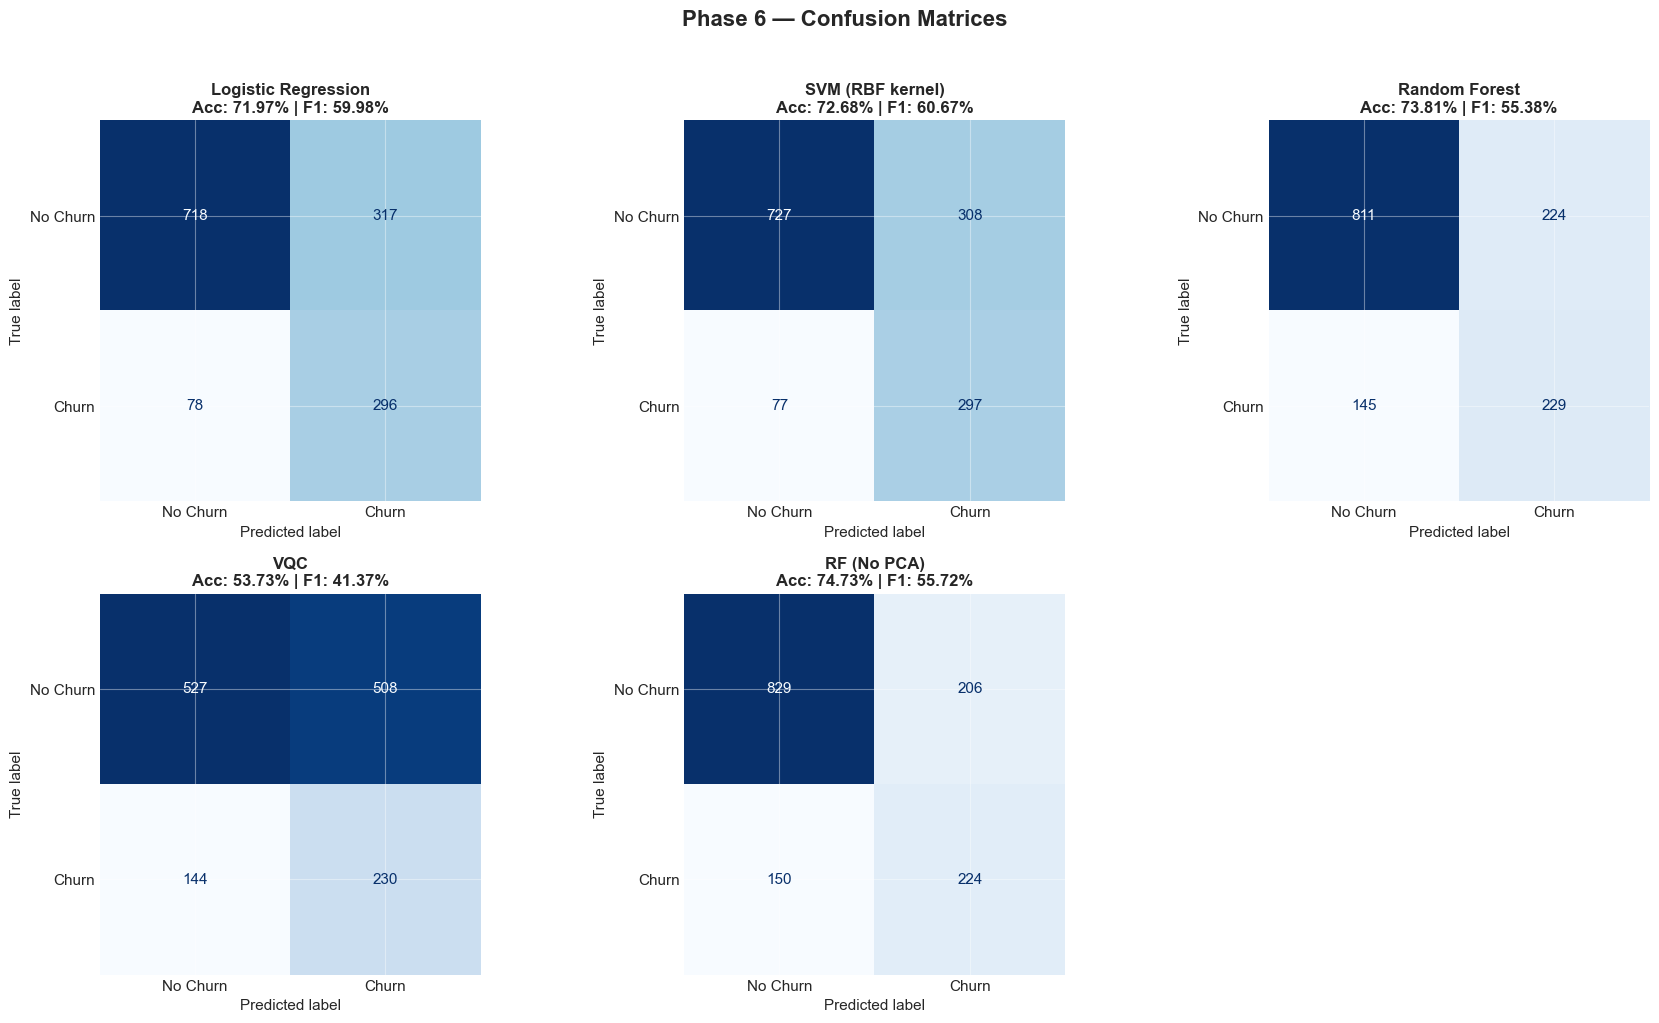

✅ Saved: phase6_confusion_matrices.png


In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

y_true = y_vqc_test

n_models = len(results)
ncols = 3
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))

# If only one row, axes may not be 2D
if nrows == 1:
    axes = [axes] if n_models == 1 else axes.flatten()
else:
    axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):

    # If your results dict directly stores predictions,
    # replace res["predictions"] with res
    y_pred = res["predictions"]

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["No Churn", "Churn"]
    )

    disp.plot(ax=axes[i], colorbar=False, cmap="Blues")

    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100

    axes[i].set_title(
        f"{name}\nAcc: {acc:.2f}% | F1: {f1:.2f}%",
        fontsize=12,
        fontweight="bold"
    )

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Phase 6 — Confusion Matrices", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("phase6_confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved: phase6_confusion_matrices.png")

NameError: name 'roc_curve' is not defined

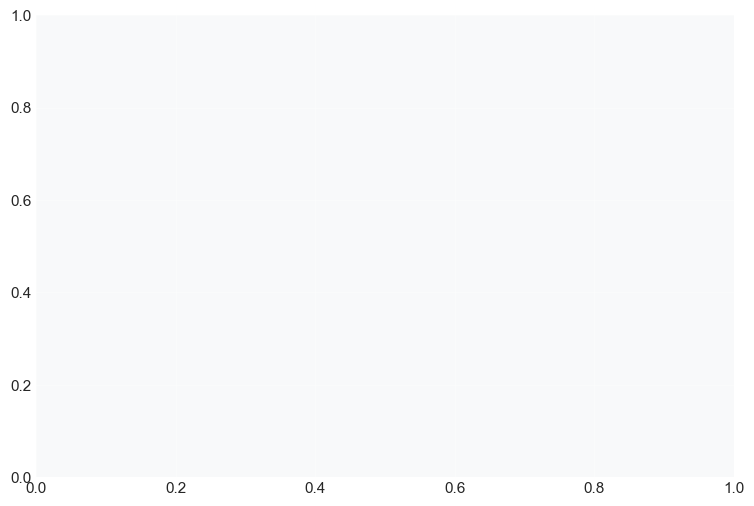

In [88]:
fig, ax = plt.subplots(figsize=(9, 6))

COLORS = ["#4C8BE2", "#F39C12", "#2ECC71", "#E25C5C", "#9B59B6"]

for (name, res), color in zip(results.items(), COLORS):
    y_pred = res["predictions"]
    
    # Use predict_proba if available, else use binary predictions as scores
    model = res.get("model", None)
    if model is not None and hasattr(model, "predict_proba"):
        y_score = model.predict_proba(
            X_test_pca if name != "RF (No PCA)" else X_test
        )[:, 1]
    else:
        # VQC — use binary predictions as score
        y_score = y_pred.astype(float)
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc     = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=color, linewidth=2.5,
            label=f"{name}  (AUC = {roc_auc:.3f})")

ax.plot([0, 1], [0, 1], "k--", linewidth=1.2, label="Random classifier")
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate",  fontsize=12)
ax.set_title("Phase 6 — ROC Curves", fontweight="bold", fontsize=14)
ax.legend(fontsize=10, loc="lower right")
ax.set_xlim(0, 1); ax.set_ylim(0, 1.02)

plt.tight_layout()
plt.savefig("phase6_roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅  Saved: phase6_roc_curves.png")